<a href="https://colab.research.google.com/github/FarhanDhanani/joker-clef-22-FAST-MT/blob/main/JOKER_CLEF_TASK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> This notebook is prepared to submit the solutions to the JOKER CLEF conference from the FAST-MT Team.</center></h1>

<center><img src="https://upload.wikimedia.org/wikipedia/en/e/e4/National_University_of_Computer_and_Emerging_Sciences_logo.png"/></center>

A simple set of booleans that represents the notebook is running on google colab or locally. And the model are already downloaded and loaded either on G-Drive or locally or it needs to be downloaded from the checkpoint repository.

In [ ]:
'''
## A set of simple booleeans:
##  - (run_on_colab) = True : if notebook is running on colab
##  - (run_on_colab) = False : if notebook is running locally
'''
run_on_colab = True

'''
##  - (download_bert_token_classification_for_location_extraction) = True : if BERT Model needs to get download from given checkpoint
##  - (download_bert_token_classification_for_location_extraction) = False : if  BERT Model is already downloaded and its path is step
'''
download_bert_token_classification_for_location_extraction = True

'''
##  - (distil_bert_text_classification) = True : if Distil-BERT Model is already downloaded and its path is step
##  - (distil_bert_text_classification) = False : if  Distil-BERT Model needs to get download from given checkpoint
'''
download_distil_bert_text_classification = True

Installing required dependencies and setuping base paths

In [ ]:
if run_on_colab:
    from google.colab import drive
    from google.colab import files
    base_path = '/content/drive'
    drive.mount(base_path)
    base_path = base_path + '/My Drive/'

    ## UPLOADING REQUIREMENTS.TXT
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

    ## INSTALLING ALL DEPENDENCIES
    !pip3 install -r requirements_task1.txt

else:
    base_path = '/Users/fdhanani/Desktop/JOKER CLEF/'
    ## INSTALLING ALL DEPENDENCIES
    !pip3 install -r requirements_task1.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving requirements_task1.txt to requirements_task1 (2).txt
User uploaded file "requirements_task1.txt" with length 2468 bytes
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import enum
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from keybert import KeyBERT
from accelerate import Accelerator
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from keybert.backend import BaseEmbedder
from sklearn.model_selection import train_test_split
from datasets import load_metric, Dataset, Features, Sequence, Value, ClassLabel, DatasetDict

from transformers import TFAutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import get_scheduler, pipeline, create_optimizer, BertTokenizer, BertModel
from transformers import AdamW, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification

Before executing the subsequent notebook cells, please clone all the related files from the [official Github repository](https://github.com/FarhanDhanani/joker-clef-22-FAST-MT). And ensure the mentioned directory structure is set up correctly either on the Google Drive if you are executing on the collab or your local system, in case you are running it locally. 

**DIRECTORY STRUCTURE:** 
```
.
├── JOKER_CLEF_TASK_1.ipynb
├── JOKER_CLEF_TASK_2.ipynb
├── JOKER_CLEF_TASK_3.ipynb
├── requirements_task1.txt
├── requirements_task2.txt
├── requirements_task3.txt
│── Readme.md
├── dataset
│   └── JOKER
│       ├── Task 1
│       │   ├── test
│       │   │   ├── check_format.py
│       │   │   ├── joker_task1_en_test.csv
│       │   │   ├── joker_task1_en_test.json
│       │   │   └── joker_task1_en_testfull.json
│       │   └── train
│       │       ├── FT_Model
│       │       │   ├── FINE_TUNED_MODELS_FOR_TASK1_WILL_SAVE_HERE
|       |       |   ├── TFDistilBertForSequenceClassification
│       │       │   │   ├── finetuned model TFDistilBertForSequenceClassification
│       │       │   ├── TFDistilBertForSequenceClassificationOfConventionalType
│       │       │   │   ├── finetuned model TFDistilBertForSequenceClassificationOfConventionalType
│       │       │   ├── TFDistilBertForSequenceClassificationOfCulturalReferenceType
│       │       │   │   ├── finetuned model TFDistilBertForSequenceClassificationOfCulturalReferenceType
│       │       │   ├── TFDistilBertForSequenceClassificationOfHorizontalVerticalType
│       │       │   │   ├── finetuned model TFDistilBertForSequenceClassificationOfHorizontalVerticalType
│       │       │   ├── TFDistilBertForSequenceClassificationOfManipulationType
│       │       │   │   ├── finetuned model TFDistilBertForSequenceClassificationOfManipulationType
│       │       │   ├── bert-finetuned-ner-JOKER_task1
│       │       │   │   ├── finetuned model ner-JOKER_task1
│       │       │   ├── bert-finetuned-ner-location-JOKER_task1
│       │       │   │   ├── finetuned model location-JOKER_task1
│       │       ├── joker_task1_en_train.csv
│       │       ├── joker_task1_en_train.json
│       │       ├── joker_task1_en_trainfull.json
│       │       ├── train_val_split
│       │       │   ├── train1.csv
│       │       │   ├── train1.json
│       │       │   ├── val1.csv
│       │       │   └── val1.json
│       ├── Task 2
│       │   ├── test
│       │   │   ├── CAMEM-solutions_joker_task2_test_context_aware_data_where_answers_exist.json
│       │   │   ├── DISTIL-solutions_joker_task2_test_context_aware_data_where_answers_exist.json
│       │   │   ├── check_format.py
│       │   │   ├── joker_task2_test.csv
│       │   │   ├── joker_task2_test.json
│       │   │   ├── joker_task2_test_context_aware_data_where_answers_exist.csv
│       │   └── train
│       │       ├── FT_Model
│       │       │   ├── camembert-base-squadFR-fquad-piaf
│       │       │   │   ├── Fine-tuned camembert model will save here
│       │       │   └── distilbert-base-cased-distilled-squad
│       │       │       ├── Fine-tuned distilbert model will save here
│       │       ├── joker_task2_train.csv
│       │       ├── joker_task2_train.json
│       │       ├── joker_task2_train_context_aware_data_where_answers_exist.csv
│       │       └── train_val_split
│       │           ├── train2.csv
│       │           └── val2.csv
│       ├── Task 3
│       │   ├── test
│       │   │   ├── check_format.py
│       │   │   ├── joker_task3_test.csv
│       │   │   └── joker_task3_test.json
│       │   └── train
│       │       ├── Helsinki-NLP-performance.json
│       │       ├── joker_task3_train.csv
│       │       ├── joker_task3_train.json
│       │       ├── t5-base-performance.json
│       │       ├── t5-large-performance.json
│       │       └── t5-small-performance.json
│       ├── csv
│       │   ├── context
│       │   │   ├── c_ref_test.csv
│       │   │   └── c_ref_train.csv
│       │   ├── en-fr_books.csv
│       │   ├── en-fr_bookshop.csv
│       │   ├── en-fr_opensub.csv
│       │   ├── en-fr_ted.csv
│       │   ├── en-fr_wiki.csv
│       │   ├── en-fr_wikipedia.csv
│       │   ├── en_processed
│       │   │   ├── en-fr_books.csv
│       │   │   ├── en-fr_bookshop.csv
│       │   │   ├── en-fr_opensub.csv
│       │   │   ├── en-fr_ted.csv
│       │   │   ├── en-fr_wiki.csv
│       │   │   └── en-fr_wikipedia.csv
│       │   └── 
│       ├── en-fr_books.tmx
│       ├── en-fr_bookshop.tmx
│       ├── en-fr_opensub.tmx
│       ├── en-fr_ted.tmx
│       ├── en-fr_wiki.tmx
│       ├── en-fr_wikipedia.tmx
│       ├── dragons.csv
│       ├── task2_pokemon_en.json
│       └── task2_pokemon_fr.json
├── models
|   |── Downloaded Pre-trained Models will get save here
│   ├── Helsinki-NLP-opus-mt-en-fr
│   │   
│   ├── bert-base-cased
│   │   
│   ├── camembert-base-squadFR-fquad-piaf
│   │   
│   ├── distilbert-base-cased-distilled-squad
│   │   
│   ├── distilbert-base-uncased
│   │   
│   ├── mt5-small
│   │   
│   ├── roberta-base
│   │   
│   └── t5-base
│       
├── .
```

# **TASK 1: CLASSIFY AND EXPLAIN INSTANCES of WORDPLAY**

Train data format: List of classified wordplay instances in a JSON format or a CSV file (for manual runs) with the following fields:

    ID: a unique wordplay identifier
    
    WORDPLAY: wordplay text
    
    TARGET_WORD: word(s)
    
    DISAMBIGUATION: explanation of the wordplay
    
    HORIZONTAL/VERTICAL: co-presence of source and target of the wordplay. In horizontal wordplay, both the source and the target of the wordplay are given (ex. 1: “They’re called lessons because they lessen from day to day”); in vertical wordplay, source and target are collapsed in a single occurrence (ex. 2: “How do you make a cat drink? Easy: put it in a liquidizer”)
    
    MANIPULATION_TYPE: Identity (source and target are formally identical, as in ex. 2 above); Similarity (as in ex. 1 above: source and target are not perfectly identical, but the resemblance is obvious); Permutation (the textual material is given a new order, as in anagrams or spoonerism. Ex. 3: “Dormitory = dirty room”); Abbreviation (an ad-hoc category for textual material where the initials form another meaning, as in acrostics or “funny” acronyms. Ex. 4: “BRAINS: Biobehavioral Research Awards for Innovative New Scientists”)
    
    MANIPULATION_LEVEL: most wordplay involves some kind of phonological manipulation – that’s why Sound will be the default category. Examples 1 and 2 involve a clear sound similarity (ex. 1) or identity (ex. 2). Only if this category cannot be applied to the wordplay should you look for another level of manipulation. First consider whether the manipulation involves Writing (as in ex. 3 and 4). If neither Sound nor Writing are manipulated, specify the level of manipulation as Other. This level of manipulation may arise, for instance, in chiasmuses (ex. 5: “We shape our buildings, and afterwards our buildings shape us”).
    
    CULTURAL_REFERENCE: this is a binary (True/False) category. In order to understand some instances of wordplay, one has to be aware of some extra-linguistic factors
    
    CONVENTIONAL_FORM: this is a binary (True/False) category, e.g. Tom Swifty (wellerism), Monsieur et Madame… ont un fils
    
    OFFENSIVE (not evaluated category): some wordplay instances are marked as offensive.


Example:Train data format: 

    [{"ID":"noun_1063","WORDPLAY":"Elimentaler","TARGET_WORD":"Elimentaler","DISAMBIGUATION":"Emmental (cheese) + Eliminator","HORIZONTAL\/VERTICAL":"vertical","MANIPULATION_TYPE":"Similarity","MANIPULATION_LEVEL":"Sound","CULTURAL_REFERENCE":false,"CONVENTIONAL_FORM":false,"OFFENSIVE":null},{"ID":"pun_341","WORDPLAY":"Geologists can be sedimental about their work.","TARGET_WORD":"sedimental","DISAMBIGUATION":"sentimental\/sediment","HORIZONTAL\/VERTICAL":"vertical","MANIPULATION_TYPE":"Similarity","MANIPULATION_LEVEL":"Sound","CULTURAL_REFERENCE":false,"CONVENTIONAL_FORM":false,"OFFENSIVE":null}]

Test data input format: List of wordplay instances to classify in a JSON format or a CSV file (for manual runs) with the following fields:

    ID: a unique wordplay identifier
    WORDPLAY: wordplay text

Input example:

    [{"ID":"noun_1","WORDPLAY":"Ambipom"},{"ID":"het_1011","WORDPLAY":"These are my parents, said Einstein relatively"}]

Test data output format:

List of wordplay instances to be classified in a JSON format or a CSV file (for manual runs) with the following fields:

    RUN_ID: Run ID starting with team_id_ (as registered at the CLEF website)
    
    MANUAL: Whether the run is manual {0,1}
    
    ID: a unique wordplay identifier from the input file
    
    WORDPLAY: wordplay text
    
    TARGET_WORD: word(s)
    
    DISAMBIGUATION: explanation of the wordplay
    
    HORIZONTAL/VERTICAL: co-presence of source and target of the wordplay (horizontal/vertical)
    
    MANIPULATION_TYPE: Identity/Similarity/Permutation/Abbreviation
    
    MANIPULATION_LEVEL: Sound/Writing/Other.
    
    CULTURAL_REFERENCE: this is a binary (True/False) category. In order to understand some instances of wordplay, one has to be aware of some extra-linguistic factors
    
    CONVENTIONAL_FORM: this is a binary (True/False) category, e.g. Tom Swifty (wellerism), Monsieur et Madame… ont un fils
    
    OFFENSIVE (not evaluated category): some wordplay instances are marked as offensive.

Output example:

    [{"RUN_ID":"RT","MANUAL":1,"ID":"noun_1063","WORDPLAY":"Elimentaler","TARGET_WORD":"Elimentaler","DISAMBIGUATION":"Emmental (cheese) + Eliminator","HORIZONTAL\/VERTICAL":"vertical","MANIPULATION_TYPE":"Similarity","MANIPULATION_LEVEL":"Sound","CULTURAL_REFERENCE":false,"CONVENTIONAL_FORM":false,"OFFENSIVE":null},{"RUN_ID":"RT","MANUAL":1,"ID":"pun_341","WORDPLAY":"Geologists can be sedimental about their work.","TARGET_WORD":"sedimental","DISAMBIGUATION":"sentimental\/sediment","HORIZONTAL\/VERTICAL":"vertical","MANIPULATION_TYPE":"Similarity","MANIPULATION_LEVEL":"Sound","CULTURAL_REFERENCE":false,"CONVENTIONAL_FORM":false,"OFFENSIVE":null}]


**Evaluation**. Pilot Task 1 includes both classification and interpretation components. Classification performance will be evaluated with respect to accuracy, while interpretation performance will be evaluated semi-manually.

**Result submission**. Participants should put their run results into the folder Documents created for their user and submit them by email to contact@joker-project.com. The email subject has to be in the format [CLEF TASK 1] TEAM_ID.


## LOADING THE DATASETS

Loading the train dataset for task-1

In [ ]:
'''
## The train data file were given in the form of json format.
## We have load them into pandas dataframe for further analysis.
'''

path = "/dataset/JOKER/Task 1/train/joker_task1_en_trainfull.json"
data_set_1 = pd.read_json(base_path+path)
data_set_1.head(5)

,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
0,en_train_0,Dentists don't like a hard day at the orifice.,orifice,orifice/office,vertical,Similarity,Sound,False,0.0,None
1,en_train_1,Diets are for people who are thick and tired o...,thick,thick/sick,vertical,Similarity,Sound,False,0.0,None
2,en_train_2,Follow your knows.,knows,knows/nose,vertical,Similarity,Sound,False,0.0,None
3,en_train_3,Two astronauts who were dating put an end to i...,space,space (area around objects) / space (area betw...,vertical,Identity,Sound,False,0.0,None
4,en_train_4,Yesterday a cow saved my life - it was bovine ...,bovine,bovine/divine/heavenly/divine/heavenly,vertical,Similarity,Sound,False,0.0,None


The structure of train dataset

In [ ]:
'''
 ## Determining the structure of the training data set.
'''
data_set_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077 entries, 0 to 2076
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2077 non-null   object 
 1   WORDPLAY             2077 non-null   object 
 2   LOCATION             2077 non-null   object 
 3   INTERPRETATION       2077 non-null   object 
 4   HORIZONTAL/VERTICAL  2077 non-null   object 
 5   MANIPULATION_TYPE    2076 non-null   object 
 6   MANIPULATION_LEVEL   2077 non-null   object 
 7   CULTURAL_REFERENCE   2077 non-null   bool   
 8   CONVENTIONAL_FORM    1611 non-null   float64
 9   OFFENSIVE            18 non-null     object 
dtypes: bool(1), float64(1), object(8)
memory usage: 148.2+ KB


Loading the test dataset for task-1

In [ ]:
'''
## The test data file were given in the form of json format.
## We have load them into pandas dataframe for further analysis.
'''
path = "/dataset/JOKER/Task 1/test/joker_task1_en_testfull.json"
data_set_test_1 = pd.read_json(base_path+path)
data_set_test_1.head(5)

,ID,WORDPLAY
0,en_test_0,Cliff hanger
1,en_test_1,Maggey Byrde
2,en_test_2,Vase-tly overpowered
3,en_test_3,Rock 'n' goal
4,en_test_4,An ice idea


The structure of test dataset

In [ ]:
'''
 ## Determining the structure of the testing data set.
'''
data_set_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3256 entries, 0 to 3255
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        3256 non-null   object
 1   WORDPLAY  3255 non-null   object
dtypes: object(2)
memory usage: 51.0+ KB


## EDA FOR THE LOADED DATASET

TOTAL NUMBER OF RECORDS IN TEST DATA SET

In [ ]:
len(data_set_test_1)

3256

NUMBER OF MISSING VALUES IN EACH COLUMN of TEST DATASET

In [ ]:
data_set_test_1.isnull().sum()

ID          0
WORDPLAY    1
dtype: int64

In [ ]:
data_set_test_1[data_set_test_1.WORDPLAY.isna()]

,ID,WORDPLAY
367,en_test_367,None


TOTAL NUMBER OF RECORDS IN TRAINING DATA SET

In [ ]:
'''
 ## The number of total records in the given training data set.
'''
len(data_set_1)

2077

NUMBER OF MISSING VALUES IN EACH COLUMN OF TRAINING DATASET

In [ ]:
'''
 ## Finding out total Number of missing cells in the given training data set.
'''
data_set_1.isnull().sum()

ID                        0
WORDPLAY                  0
LOCATION                  0
INTERPRETATION            0
HORIZONTAL/VERTICAL       0
MANIPULATION_TYPE         1
MANIPULATION_LEVEL        0
CULTURAL_REFERENCE        0
CONVENTIONAL_FORM       466
OFFENSIVE              2059
dtype: int64

### EXPLORING OFFENSIVE VARIABLE GIVEN IN THE TRAINING DATA SET

In [ ]:
'''
 ## Finding out the description data related to OFFENSIVE variable.
'''

data_set_1.OFFENSIVE.describe()

count         18
unique         4
top       Sexist
freq           9
Name: OFFENSIVE, dtype: object

Distinct values of the OFFENSIVE variable provided in the train dataset

In [ ]:
'''
 ## Finding out the distinct values of the OFFENSIVE variable.
'''

data_set_1.OFFENSIVE.unique()

array([None, 'Racist', 'Possibly', 'Sexist', 'Other'], dtype=object)

In [ ]:
'''
 ## Total number of records where the OFFENSIVE variable is null.
'''

len(data_set_1[data_set_1.OFFENSIVE.isna()])

2059

In [ ]:
'''
 ## Total number of records where the OFFENSIVE variable is not null.
'''

len(data_set_1[data_set_1.OFFENSIVE.notna()])

18

In [ ]:
'''
 ## Finding out the records where OFFENSIVE variable is not null.
'''

data_set_1[data_set_1.OFFENSIVE.notna()]

,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
66,en_train_66,"I'd like to be a Chinese laborer, said Tom coo...",coolly,coolly / coolie,vertical,Identity,Sound,True,1.0,Racist
114,en_train_114,"She was only a Cyclist's daughter, but she ped...",peddled,peddle / pedal,vertical,Similarity,Sound,False,1.0,Possibly
115,en_train_115,"She was only a Farmer's daughter, but she was ...",hoer,hoer (whore) / hoe (gardening tool),vertical,Similarity,Sound,False,1.0,Sexist
116,en_train_116,"She was only a Fruit vender's daughter, but, o...",peach,peach (fruit) / peach (sweet person) ~ bitch,vertical,Identity,Sound,False,1.0,Possibly
117,en_train_117,"She was only a Gardener's daughter, but she kn...",rakes,rake (gardening tool) / rake (libertine),vertical,Identity,Sound,False,1.0,Sexist
119,en_train_119,"She was only a Real estate agent's daughter, b...",lot,lot (housing) / lot (many),vertical,Similarity,Sound,False,1.0,Possibly
212,en_train_212,As I revived her using mouth to mouth resuscit...,breaths,breath / breast,vertical,Similarity,Sound,False,0.0,Sexist
232,en_train_232,Did you hear the one about the guy with the br...,hear,entendre,vertical,Permutation,Sound,False,0.0,Possibly
238,en_train_238,Enough with the crippling jokes! I can't stand...,can't stand them,can't stand = ne pas supporter / ne pas tenir ...,vertical,Identity,Sound,False,0.0,Other
358,en_train_358,"She was only a Catcher's daughter, but she had...",balls,balls (baseballs) / balls (testicles),vertical,Identity,Sound,False,1.0,Sexist


### EXPLORING CONVENTIONAL FORM BINARY VAIRABLE

In [ ]:
'''
 ## Finding out description data related to CONVENTIONAL_FORM variable.
'''

data_set_1.CONVENTIONAL_FORM.describe()

count    1611.000000
mean        0.103042
std         0.304108
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: CONVENTIONAL_FORM, dtype: float64

In [ ]:
'''
 ## Finding out the distinct values of the CONVENTIONAL_FORM variable.
'''

data_set_1.CONVENTIONAL_FORM.unique()

array([ 0.,  1., nan])

In [ ]:
'''
 ## Total number of records where the CONVENTIONAL_FORM variable is not null.
'''

len(data_set_1[data_set_1.CONVENTIONAL_FORM.isna()])

466

<AxesSubplot:>

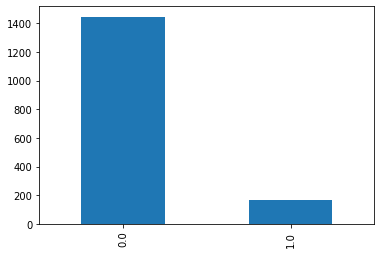

In [ ]:
'''
 ## Comparing frequencies of boolean variable CONVENTIONAL_FORM.
'''

data_set_1.CONVENTIONAL_FORM.value_counts().plot(kind='bar')

In [ ]:
'''
 ## Listing frequencies of boolean variable CONVENTIONAL_FORM.
'''

data_set_1.CONVENTIONAL_FORM.value_counts()

0.0    1445
1.0     166
Name: CONVENTIONAL_FORM, dtype: int64

In [ ]:
'''
 ## Listing records where variable CONVENTIONAL_FORM has a value of TRUE or 1.0.
'''

print("Number of records where the CONVENTIONAL_FORM is true ",len(data_set_1[data_set_1.CONVENTIONAL_FORM==True]))
data_set_1[data_set_1.CONVENTIONAL_FORM==True]

Number of records where the CONVENTIONAL_FORM is true  166


,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
5,en_train_5,How do you fix a damaged jack-o-lantern? You u...,patch,une rustine / une parcelle,vertical,Identity,Sound,False,1.0,None
7,en_train_7,What did Jay-Z call his wife before they got m...,Feyonce,Beyonce / Fiancée,vertical,Similarity,Sound,True,1.0,None
8,en_train_8,What did the Red light say to the Green light?...,changing,change (become different) / change (undress an...,vertical,Identity,Sound,False,1.0,None
9,en_train_9,What do you do on a remote island? Try and fin...,remote,remote (far) / remote (zapper),vertical,Identity,Sound,False,1.0,None
10,en_train_10,What is a tornado's favorite game to play? Twi...,Twister,twister (tornado) / Twister (game),vertical,Identity,Sound,False,1.0,None
...,...,...,...,...,...,...,...,...,...,...
630,en_train_630,"She was only a Wrestler's daughter, but you ou...",box,box {sport} / box (female genitalia),vertical,Identity,Sound,False,1.0,Sexist
635,en_train_635,"""Boy, that's a bright star,""said Tom seriously.",tee,serious / sirius,vertical,Similarity,Sound,False,1.0,None
636,en_train_636,"""I've been listening to the Brandenberg Concer...",barked,Barked / Bach (Johann Sebastian Bach) +ed,vertical,Similarity,Sound,True,1.0,None
637,en_train_637,"""She was only a Real estate agent""s daughter, ...",coached,coach (instruct) /coach (four wheels carriage),vertical,Identity,Sound,False,1.0,None


### EXPLORING CULTURAL REFERENCE BINARY VAIRABLE

In [ ]:
'''
 ## Finding out description data related to CULTURAL REFERENCE variable.
'''

data_set_1.CULTURAL_REFERENCE.describe()

count      2077
unique        2
top       False
freq       1983
Name: CULTURAL_REFERENCE, dtype: object

In [ ]:
'''
 ## Finding out the distinct values of the CULTURAL REFERENCE variable.
'''

data_set_1.CULTURAL_REFERENCE.unique()

array([False,  True])

<AxesSubplot:>

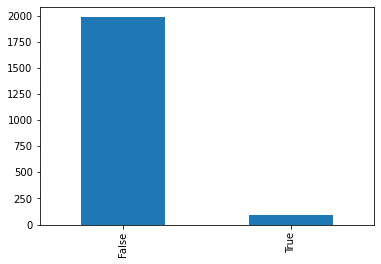

In [ ]:
'''
 ## Comparing frequencies of boolean variable CULTURAL REFERENCE.
'''

data_set_1.CULTURAL_REFERENCE.value_counts().plot(kind='bar')

In [ ]:
'''
 ## Listing frequencies of boolean variable CULTURAL_REFERENCE.
'''

data_set_1.CULTURAL_REFERENCE.value_counts()

False    1983
True       94
Name: CULTURAL_REFERENCE, dtype: int64

In [ ]:
'''
 ## Listing records where variable CULTURAL_REFERENCE has a value of TRUE.
'''

print("Number of records where the CULTURAL_REFERENCE is true ",len(data_set_1[data_set_1.CULTURAL_REFERENCE==True]))
data_set_1[data_set_1.CULTURAL_REFERENCE==True]

Number of records where the CULTURAL_REFERENCE is true  94


,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
7,en_train_7,What did Jay-Z call his wife before they got m...,Feyonce,Beyonce / Fiancée,vertical,Similarity,Sound,True,1.0,None
21,en_train_21,"""Once upon a time there was a beautiful prince...",grimly,grim / Grimm (brothers Grimm),vertical,Similarity,Sound,True,1.0,None
66,en_train_66,"I'd like to be a Chinese laborer, said Tom coo...",coolly,coolly / coolie,vertical,Identity,Sound,True,1.0,Racist
71,en_train_71,I've been to a film festival in the South of F...,cannily,cannily/cannes,vertical,Similarity,Sound,True,1.0,None
143,en_train_143,Wheaties near the body suggested that police l...,Wheaties,Wheaties / Witnesses,vertical,Similarity,Sound,True,0.0,None
...,...,...,...,...,...,...,...,...,...,...
1860,en_train_1862,Fawkes,Fawkes,Fawkes (Guy Fawkes),vertical,Identity,Sound,True,NaN,None
1866,en_train_1868,Mrs Norris,Mrs Norris,[0],vertical,Identity,Sound,True,NaN,None
1874,en_train_1876,Florean Fortescue,Florean Fortescue,Fortescue (Sir Adrian Fortescue),vertical,Identity,Sound,True,NaN,None
1880,en_train_1882,Burke,Burke,Burke (William Burke),vertical,Identity,Sound,True,NaN,None


### EXAMINING BINARY VARIABLES CULTURAL_REFERENCE AND CONVENTIONAL_FORM TOGETHER

In [ ]:
'''
 ## Listing the number of records where CULTURAL_REFERENCE and CONVENTIONAL_FORM have same values.
'''

print("Number of records where the CULTURAL_REFERENCE AND CONVENTIONAL_FORM have same values ", len(data_set_1[data_set_1.CULTURAL_REFERENCE == data_set_1.CONVENTIONAL_FORM]))

Number of records where the CULTURAL_REFERENCE AND CONVENTIONAL_FORM have same values  1394


In [ ]:
'''
 ## Listing the number of records where CULTURAL_REFERENCE and CONVENTIONAL_FORM are both True.
'''

print("Number of records where the CULTURAL_REFERENCE AND CONVENTIONAL_FORM are both True ", len(data_set_1[(data_set_1.CULTURAL_REFERENCE == True) & (data_set_1.CONVENTIONAL_FORM==1.0)]))

Number of records where the CULTURAL_REFERENCE AND CONVENTIONAL_FORM are both True  17


In [ ]:
'''
 ## Listing the number of records where CULTURAL_REFERENCE and CONVENTIONAL_FORM are both False.
'''

print("Number of records where the CULTURAL_REFERENCE AND CONVENTIONAL_FORM are both False ", len(data_set_1[(data_set_1.CULTURAL_REFERENCE == False) & (data_set_1.CONVENTIONAL_FORM==0.0)]))

Number of records where the CULTURAL_REFERENCE AND CONVENTIONAL_FORM are both False  1377


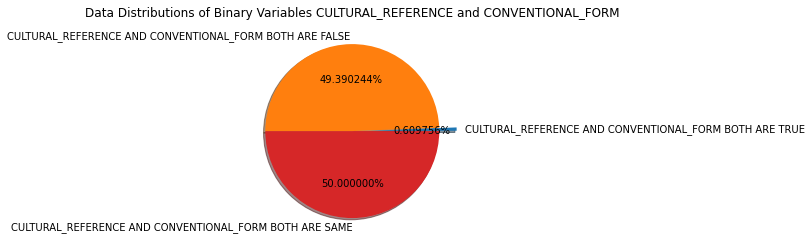

In [ ]:
labels = ['CULTURAL_REFERENCE AND CONVENTIONAL_FORM BOTH ARE SAME', 
        'CULTURAL_REFERENCE AND CONVENTIONAL_FORM BOTH ARE TRUE',
        'CULTURAL_REFERENCE AND CONVENTIONAL_FORM BOTH ARE FALSE',]
 
data = [
        len(data_set_1[data_set_1.CULTURAL_REFERENCE == data_set_1.CONVENTIONAL_FORM]), 
        len(data_set_1[(data_set_1.CULTURAL_REFERENCE == True) & (data_set_1.CONVENTIONAL_FORM==1.0)]),
        len(data_set_1[(data_set_1.CULTURAL_REFERENCE == False) & (data_set_1.CONVENTIONAL_FORM==0.0)])]

explode = [0, 0.2, 0]
colors = ['tab:red', 'tab:blue','tab:orange']
fig, ax = plt.subplots()
ax.pie(data, labels = labels, autopct='%f%%', explode=explode, shadow=True, startangle = 180, colors=colors)
ax.set_title('Data Distributions of Binary Variables CULTURAL_REFERENCE and CONVENTIONAL_FORM')

# show plot
plt.show()

### EXPLORING CATEGORICAL VARIABLE MANIPULATION_LEVEL

In [ ]:
'''
 ## Finding out description data related to MANIPULATION_LEVEL variable.
'''

data_set_1.MANIPULATION_LEVEL.describe()

count      2077
unique        3
top       Sound
freq       2067
Name: MANIPULATION_LEVEL, dtype: object

In [ ]:
'''
 ## Finding out the distinct values of the MANIPULATION_LEVEL variable.
'''

data_set_1.MANIPULATION_LEVEL.unique()

array(['Sound', 'Other', 'Writing'], dtype=object)

<AxesSubplot:>

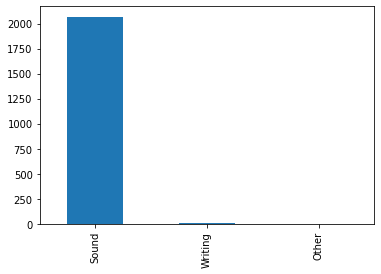

In [ ]:
'''
 ## Comparing frequencies of Categorical variable MANIPULATION_LEVEL.
'''

data_set_1.MANIPULATION_LEVEL.value_counts().plot(kind='bar')

In [ ]:
'''
 ## Listing frequencies of Categorical variable MANIPULATION_LEVEL.
'''

data_set_1.MANIPULATION_LEVEL.value_counts()

Sound      2067
Writing       8
Other         2
Name: MANIPULATION_LEVEL, dtype: int64

In [ ]:
'''
 ## Listing records where variable MANIPULATION_LEVEL doesn't have a value of "Sound."
'''

print("Number of records where the MANIPULATION_LEVEL is not Sound ",len(data_set_1[data_set_1.MANIPULATION_LEVEL!="Sound"]))
data_set_1[data_set_1.MANIPULATION_LEVEL!="Sound"]

Number of records where the MANIPULATION_LEVEL is not Sound  10


,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
202,en_train_202,A Roman walks into a bar and raises 2 fingers ...,two fingers,two fingers (V sign) / two fingers ( Roman num...,horizontal,Similarity,Other,True,0.0,None
208,en_train_208,An illiterate fisherman was lost at c.,at c,at C / at sea,vertical,Similarity,Writing,False,0.0,None
213,en_train_213,Authors can be very PENsive.,PENsive,pensive + pen,vertical,Similarity,Writing,False,0.0,None
222,en_train_222,cool cat,cat,cat (slang for person) / cat {pet},vertical,Similarity,Other,False,0.0,None
227,en_train_227,Did you hear about the cheese who saved the wo...,legend-dairy,legendary,vertical,Similarity,Writing,False,0.0,None
446,en_train_446,What does a female snake use for support? A co...,co-bra,co+bra / cobra,vertical,Similarity,Writing,False,1.0,None
594,en_train_594,"OLD ELECTRICIANS never die, they just do it un...",Hz,Hz (Hertz) / hurts,vertical,Similarity,Writing,True,1.0,None
1885,en_train_1887,Erised,Erised,Desire spelled backwards,vertical,Permutation,Writing,False,NaN,None
1894,en_train_1896,O.W.L.s,O.W.L.s,owls/Ordinary Wizarding Level,vertical,Abbreviation,Writing,False,NaN,None
1895,en_train_1897,N.E.W.T.s,N.E.W.T.s,newts/Nastily Exhausting Wizarding Test,vertical,Abbreviation,Writing,False,NaN,None


### EXPLORING CATEGORICAL VARIABLE MANIPULATION_TYPE

In [ ]:
'''
 ## Finding out description data related to MANIPULATION_TYPE variable.
'''

data_set_1.MANIPULATION_TYPE.describe()

count             2076
unique               5
top       Abbreviation
freq               771
Name: MANIPULATION_TYPE, dtype: object

In [ ]:
'''
 ## Finding out the distinct values of the MANIPULATION_TYPE variable.
'''

data_set_1.MANIPULATION_TYPE.unique()

array(['Similarity', 'Identity', 'Permutation', 'Abbreviation', None,
       '[0]'], dtype=object)

<AxesSubplot:>

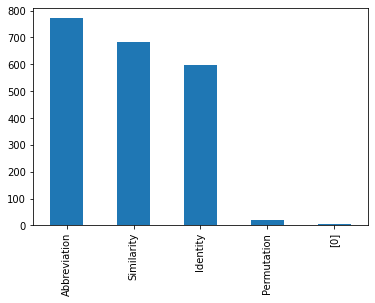

In [ ]:
'''
 ## Comparing frequencies of Categorical variable MANIPULATION_TYPE.
'''

data_set_1.MANIPULATION_TYPE.value_counts().plot(kind='bar')

In [ ]:
'''
 ## Listing frequencies of Categorical variable MANIPULATION_TYPE.
'''

data_set_1.MANIPULATION_TYPE.value_counts()

Abbreviation    771
Similarity      684
Identity        598
Permutation      19
[0]               4
Name: MANIPULATION_TYPE, dtype: int64

In [ ]:
'''
 ## Listing records where variable MANIPULATION_TYPE have a value of "Permutation."
'''

print("Number of records where the MANIPULATION_TYPE is \"Permutation\" ",len(data_set_1[data_set_1.MANIPULATION_TYPE=="Permutation"]))
data_set_1[data_set_1.MANIPULATION_TYPE=="Permutation"]

Number of records where the MANIPULATION_TYPE is "Permutation"  19


,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
232,en_train_232,Did you hear the one about the guy with the br...,hear,entendre,vertical,Permutation,Sound,False,0.0,Possibly
366,en_train_366,"So, if Australians start to export boomerangs....",export / import,export (send away) / import (get back),horizontal,Permutation,Sound,False,0.0,None
482,en_train_482,Why was Santa's little helper feeling depresse...,elf esteem,elf / self esteem,vertical,Permutation,Sound,False,0.0,None
627,en_train_627,"So, if Australians start to export boomerangs....",export / import,export (send away) / import (get back),horizontal,Permutation,Sound,False,0.0,None
949,en_train_950,Catasterous disastrophe,Catasterous disastrophe,disastrous + catastrophe,vertical,Permutation,Sound,False,0.0,None
950,en_train_951,jipping; skumping,jipping; skumping,skipping + jumping,vertical,Permutation,Sound,False,0.0,None
969,en_train_971,Jipping and skumping,Jipping and skumping,skipping + jumping,vertical,Permutation,Sound,False,0.0,None
1010,en_train_1012,Buckswashling,Buckswashling,buckswashling/swashbuckling,vertical,Permutation,Sound,False,0.0,None
1075,en_train_1077,flutterby bush,flutterby bush,"butterfly + bush\ndeliberate misspelling of ""b...",vertical,Permutation,Sound,False,0.0,None
1167,en_train_1169,Ekans,Ekans,"anagram of ""snake""",vertical,Permutation,Sound,False,0.0,None


### EXPLORING BINARY VARIABLE HORIZONTAL/VERTICAL

In [ ]:
'''
 ## Finding out description data related to HORIZONTAL/VERTICAL variable.
'''

data_set_1["HORIZONTAL/VERTICAL"].describe()

count         2077
unique           3
top       vertical
freq          2056
Name: HORIZONTAL/VERTICAL, dtype: object

In [ ]:
'''
 ## Finding out the distinct values of the "HORIZONTAL/VERTICAL" variable.
'''

data_set_1["HORIZONTAL/VERTICAL"].unique()

array(['vertical', 'horizontal', 'Abbreviation'], dtype=object)

<AxesSubplot:>

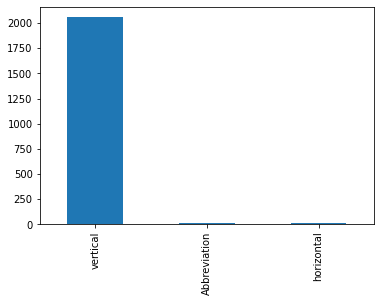

In [ ]:
'''
 ## Comparing frequencies of Categorical variable "HORIZONTAL/VERTICAL".
'''

data_set_1["HORIZONTAL/VERTICAL"].value_counts().plot(kind='bar')

In [ ]:
'''
 ## Listing frequencies of Categorical variable "HORIZONTAL/VERTICAL".
'''

data_set_1["HORIZONTAL/VERTICAL"].value_counts()

vertical        2056
Abbreviation      11
horizontal        10
Name: HORIZONTAL/VERTICAL, dtype: int64

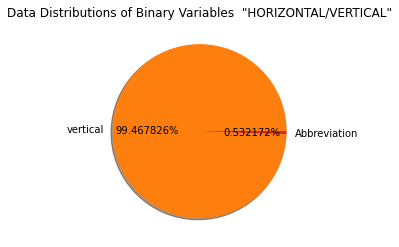

In [ ]:
'''
 ## Calculating probabilities for occurrence of binary values of variable "HORIZONTAL/VERTICAL".
'''

labels = ['vertical', 
        'Abbreviation',]
 
data = [
        data_set_1["HORIZONTAL/VERTICAL"].value_counts()[0], 
        data_set_1["HORIZONTAL/VERTICAL"].value_counts()[1],]

explode = [0, 0]
colors = ['tab:orange', 'tab:red',]
fig, ax = plt.subplots()
ax.pie(data, labels = labels, autopct='%f%%', explode=explode, shadow=True, colors=colors)
ax.set_title('Data Distributions of Binary Variables  "HORIZONTAL/VERTICAL"')
# show plot
plt.show()

### EXPLORING VARIABLE INTERPRETATION

In [ ]:
'''
 ## Finding out description data related to INTERPRETATION variable.
'''

data_set_1.INTERPRETATION.describe()

count     2077
unique    2005
top        [0]
freq        12
Name: INTERPRETATION, dtype: object

In [ ]:
'''
 ## Finding out the number of records where the interpretation has a null variable.
'''

data_set_1[data_set_1.INTERPRETATION.isna()]

,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE


In [ ]:
'''
 ## Finding out the number of records where the value of interpretation variable is not available.
'''

len(data_set_1[data_set_1.INTERPRETATION == "[0]"])

12

In [ ]:
'''
 ## Exploring records where the value of interpretation variable is not available.
'''

data_set_1[data_set_1.INTERPRETATION == "[0]"]

,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
315,en_train_315,"Jesus did the only extreme world makeover, the...",makeover,[0],vertical,Identity,Sound,False,0.0,None
1062,en_train_1064,Weasleys' Wildfire Whiz-bangs,Weasleys' Wildfire Whiz-bangs,[0],vertical,Identity,Sound,False,0.0,None
1080,en_train_1082,unspeakable,unspeakable,[0],vertical,Identity,Sound,False,0.0,None
1858,en_train_1860,Moaning,Moaning,[0],vertical,[0],Sound,False,NaN,None
1863,en_train_1865,Nearly Headless Nick,Nearly Headless Nick,[0],vertical,[0],Sound,False,NaN,None
1866,en_train_1868,Mrs Norris,Mrs Norris,[0],vertical,Identity,Sound,True,NaN,None
1884,en_train_1886,Drooble’s Best Blowing Gum,Drooble’s Best Blowing Gum,[0],vertical,[0],Sound,False,NaN,None
1887,en_train_1889,Weasley’s Wizard Wheezes,Weasley’s Wizard Wheezes,[0],vertical,[0],Sound,False,NaN,None
1890,en_train_1892,Death Eaters,Death Eaters,[0],vertical,Identity,Sound,False,NaN,None
1891,en_train_1893,Weird Sisters,Weird Sisters,[0],vertical,Identity,Sound,False,NaN,None


In [ ]:
data_set_1.INTERPRETATION[0:10]

0                                       orifice/office
1                                           thick/sick
2                                           knows/nose
3    space (area around objects) / space (area betw...
4               bovine/divine/heavenly/divine/heavenly
5                           une rustine / une parcelle
6                 on the house / "on the house" (free)
7                                    Beyonce / Fiancée
8    change (become different) / change (undress an...
9                       remote (far) / remote (zapper)
Name: INTERPRETATION, dtype: object

### EXPLORING VARIABLE LOCATION

In [ ]:
'''
 ## Finding out description data related to LOCATION variable.
'''

data_set_1.LOCATION.describe()

count     2077
unique    1997
top        bat
freq         4
Name: LOCATION, dtype: object

In [ ]:
'''
 ## Finding out number of duplicate values of the LOCATION variable.
'''

dups = data_set_1[data_set_1.duplicated(subset=['LOCATION'], keep=False)]
dups.sort_values(['LOCATION'], ascending=[1])

,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
655,en_train_655,My name is Brooks. I'm an irrrigation consultant*,Brooks,Brooks (name) / brooks (streams),vertical,Similarity,Sound,False,0.0,None
325,en_train_325,My name is Brooks. I'm an irrrigation consultant,Brooks,Brooks (name) / brooks (streams),vertical,Similarity,Sound,False,1.0,None
632,en_train_632,"""Are you homosexual ?""Tom queried gaily.",Marx,Marx (Karl Marx) / marks,vertical,Similarity,Sound,False,0.0,None
567,en_train_567,Are Philosophy papers graded with Marx out of ...,Marx,Marx (Karl Marx) / marks,vertical,Similarity,Sound,True,0.0,None
293,en_train_293,I'm thinking of setting up a comedy group to h...,Tumor,humor,vertical,Similarity,Sound,False,0.0,None
...,...,...,...,...,...,...,...,...,...,...
218,en_train_218,By yourself you're in the right. In a group yo...,throng,throng / wrong,vertical,Similarity,Sound,False,0.0,None
537,en_train_537,A waterbed may just be the vinyl resting place.,vinyl,vinyl / final,vertical,Similarity,Sound,False,0.0,None
641,en_train_641,A woman who became queen considered it her cro...,vinyl,vinyl / final,vertical,Similarity,Sound,False,0.0,None
624,en_train_624,I have a rumour about peanut butter.. But I do...,yammered,yammer / yam,vertical,Similarity,Sound,False,0.0,None


### EXPLORING VARIABLE WORDPLAY

In [ ]:
'''
 ## Finding out description data related to WORDPLAY variable.
'''

data_set_1.WORDPLAY.describe()

count                                               2077
unique                                              2077
top       Dentists don't like a hard day at the orifice.
freq                                                   1
Name: WORDPLAY, dtype: object

In [ ]:
'''
 ## Finding out number of duplicate values of the WORDPLAY variable.
'''

dups = data_set_1[data_set_1.duplicated(subset=['WORDPLAY'], keep=False)]
dups.sort_values(['WORDPLAY'], ascending=[1])

,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE


### EXPLORING LOCATION AND WORD PLAYS TOGETHER <a id='eda-wp-and-l-together'></a>

In [ ]:
'''
 ## Function to calculates number of words for each sentence given in the input array.
 
 ## INPUTS:
 # The function takes an array of strings (input sentences)
 
 ## OUTPUTS:
 # The function returns a list, where each index of the returned list contains the
 # number of words for the corresponding sentence provided in the given input array.  
'''

def word_len(text_data):
    store = []
    for i in text_data[:]:
        store.append((len(str(i).split())))
    return store

Length of Max sentence in WORDPLAY:  34
Length of Min sentence in WORDPLAY:  1
Length of Max sentence in LOCATION:  9
Length of Min sentence in LOCATION:  1


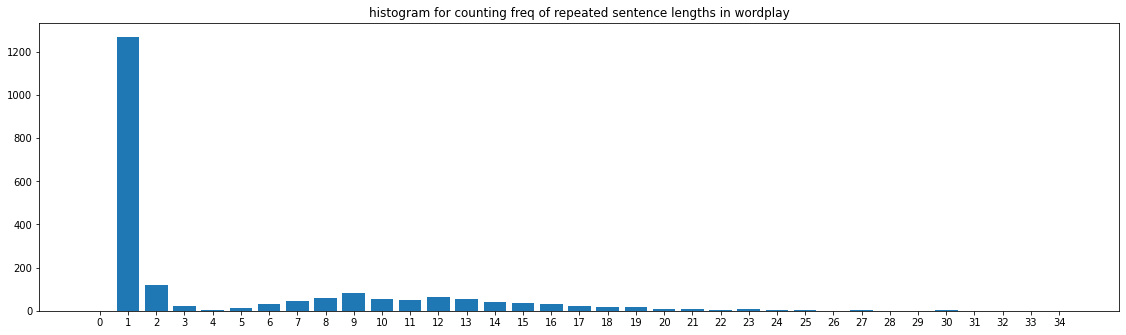

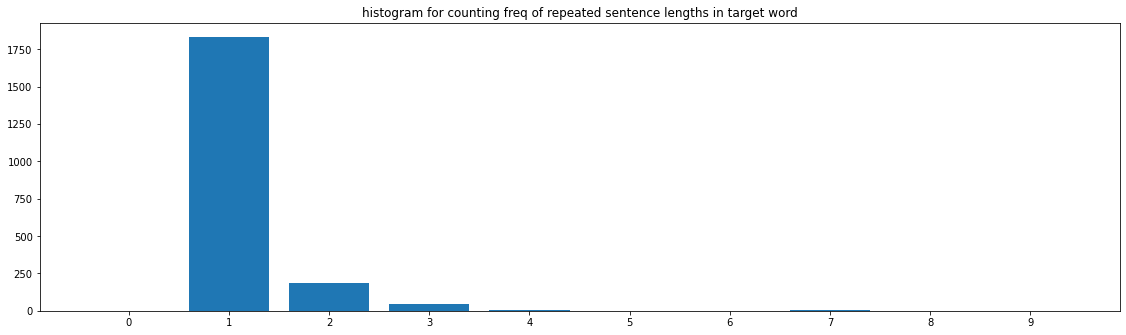

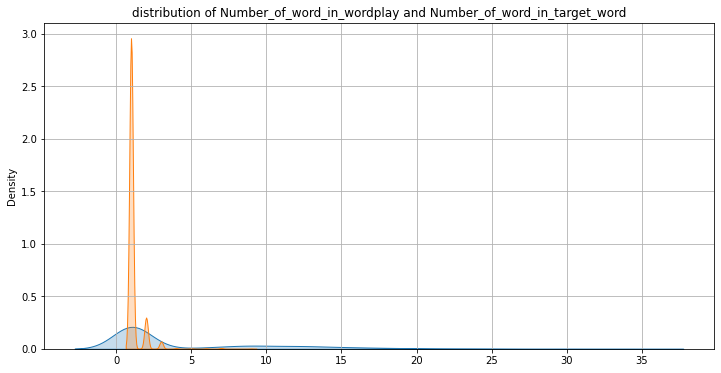

In [ ]:
'''
 ## FOR TRAINING DATASET
 
 ## Finding out value of WORDPLAY variable with the maximum length in the given trainig dataset.
 ## Finding out value of WORDPLAY variable with the minimum length in the given trainig dataset.
 ## Finding out value of LOCATION variable with the maximum length in the given trainig dataset.
 ## Finding out value of LOCATION variable with the minimum length in the given trainig dataset.
 ## Visually compare length of WORDPLAY and LOCATION variable in the given trainig dataset.
'''

num_of_words_in_wordplay = word_len(data_set_1['WORDPLAY'])
num_of_words_in_targetword = word_len(data_set_1['LOCATION'])

print("Length of Max sentence in WORDPLAY: ", max(num_of_words_in_wordplay))
print("Length of Min sentence in WORDPLAY: ", min(num_of_words_in_wordplay))

print("Length of Max sentence in LOCATION: ", max(num_of_words_in_targetword))
print("Length of Min sentence in LOCATION: ", min(num_of_words_in_targetword))


unique, counts = np.unique(num_of_words_in_wordplay, return_counts=True)
x_axis = np.arange(0, max(num_of_words_in_wordplay)+1, 1)
y_axis = np.zeros_like(x_axis)
for uni, count in zip(unique, counts):
    y_axis[uni] = count
    
fig, ax1 = plt.subplots(figsize=(15, 4))
ax1 = fig.add_axes([0,0,1,1])
ax1.bar([str(x) for x in x_axis],y_axis)
plt.title('histogram for counting freq of repeated sentence lengths in wordplay')

unique, counts = np.unique(num_of_words_in_targetword, return_counts=True)
x_axis = np.arange(0, max(num_of_words_in_targetword)+1, 1)
y_axis = np.zeros_like(x_axis)
for uni, count in zip(unique, counts):
    y_axis[uni] = count
    
fig, ax2 = plt.subplots(figsize=(15, 4))
ax2 = fig.add_axes([0,0,1,1])
ax2.bar([str(x) for x in x_axis],y_axis)
plt.title('histogram for counting freq of repeated sentence lengths in target word')

         
f, ax = plt.subplots(figsize=(12,6))
ax = sns.kdeplot(num_of_words_in_wordplay, shade= True)
ax = sns.kdeplot(num_of_words_in_targetword,shade= True )
plt.title("distribution of Number_of_word_in_wordplay and Number_of_word_in_target_word")
plt.grid()
plt.show()

In [ ]:
'''
 ## FOR TRAINING DATASEET:
 
 ## Counting number of records where the value of worplay variable is empty in train dataset.
 ## Counting number of records where the value of location variable is empty in train dataset.
 
 ## Counting number of records where the value of location and wordplay variables are same in train dataset.
 ## Counting number of records where the value of wordplay variable has length less than or equal to two in train dataset.
 ## Counting number of records where the value of wordplay variable has length greater than two in train dataset.
 ## Counting number of records where the value of the location variable has greater than one in train dataset.
'''
count_wordplay_is_empty = 0
count_location_empty = 0

coun_word_play_and_location_is_same=0
count_sent_in_wordplay_len_less_than_two=0
count_sent_in_wordplay_len_greater_than_two = 0
count_text_in_location_len_greater_than_one = 0


for i, row in data_set_1.iterrows():
    
    if(pd.isna(row["WORDPLAY"])):
        count_wordplay_is_empty+=1
        
    elif(len(row["WORDPLAY"].split())>2):
        count_sent_in_wordplay_len_greater_than_two += 1
        if(len(row["LOCATION"].split())>1):
            count_text_in_location_len_greater_than_one += 1
    else:
        count_sent_in_wordplay_len_less_than_two+=1
        if(row["WORDPLAY"] == row["LOCATION"]):
            coun_word_play_and_location_is_same+=1
    
    if(pd.isna(row["LOCATION"])):
        count_location_empty+=1

print("1-> number of reocrds in which wordplay is empty:", count_wordplay_is_empty, 
      "number of records in which target word is empty:", count_location_empty, "\n")

print("2-> count of sentences in wordplays having length greater than two is [",
      count_sent_in_wordplay_len_greater_than_two,
      "]. In which only [", count_text_in_location_len_greater_than_one
      ,"] number of target text have length greater than one\n")

print("3-> number of total records when wordplay sentences has length less than two :", 
      count_sent_in_wordplay_len_less_than_two,
     ", out of which ", coun_word_play_and_location_is_same, " records has same value in WORDPLAY and TARGET_WORD\n")

print("4-> count of total number of reecords", len(data_set_1))

1-> number of reocrds in which wordplay is empty: 0 number of records in which target word is empty: 0 

2-> count of sentences in wordplays having length greater than two is [ 688 ]. In which only [ 123 ] number of target text have length greater than one

3-> number of total records when wordplay sentences has length less than two : 1389 , out of which  1388  records has same value in WORDPLAY and TARGET_WORD

4-> count of total number of reecords 2077


Length of Max sentence in WORDPLAY in TEST SET:  97
Length of Min sentence in WORDPLAY in TEST SET:  1


Text(0.5, 1.0, 'histogram for counting freq of repeated sentence lengths in wordplay TEST SET')

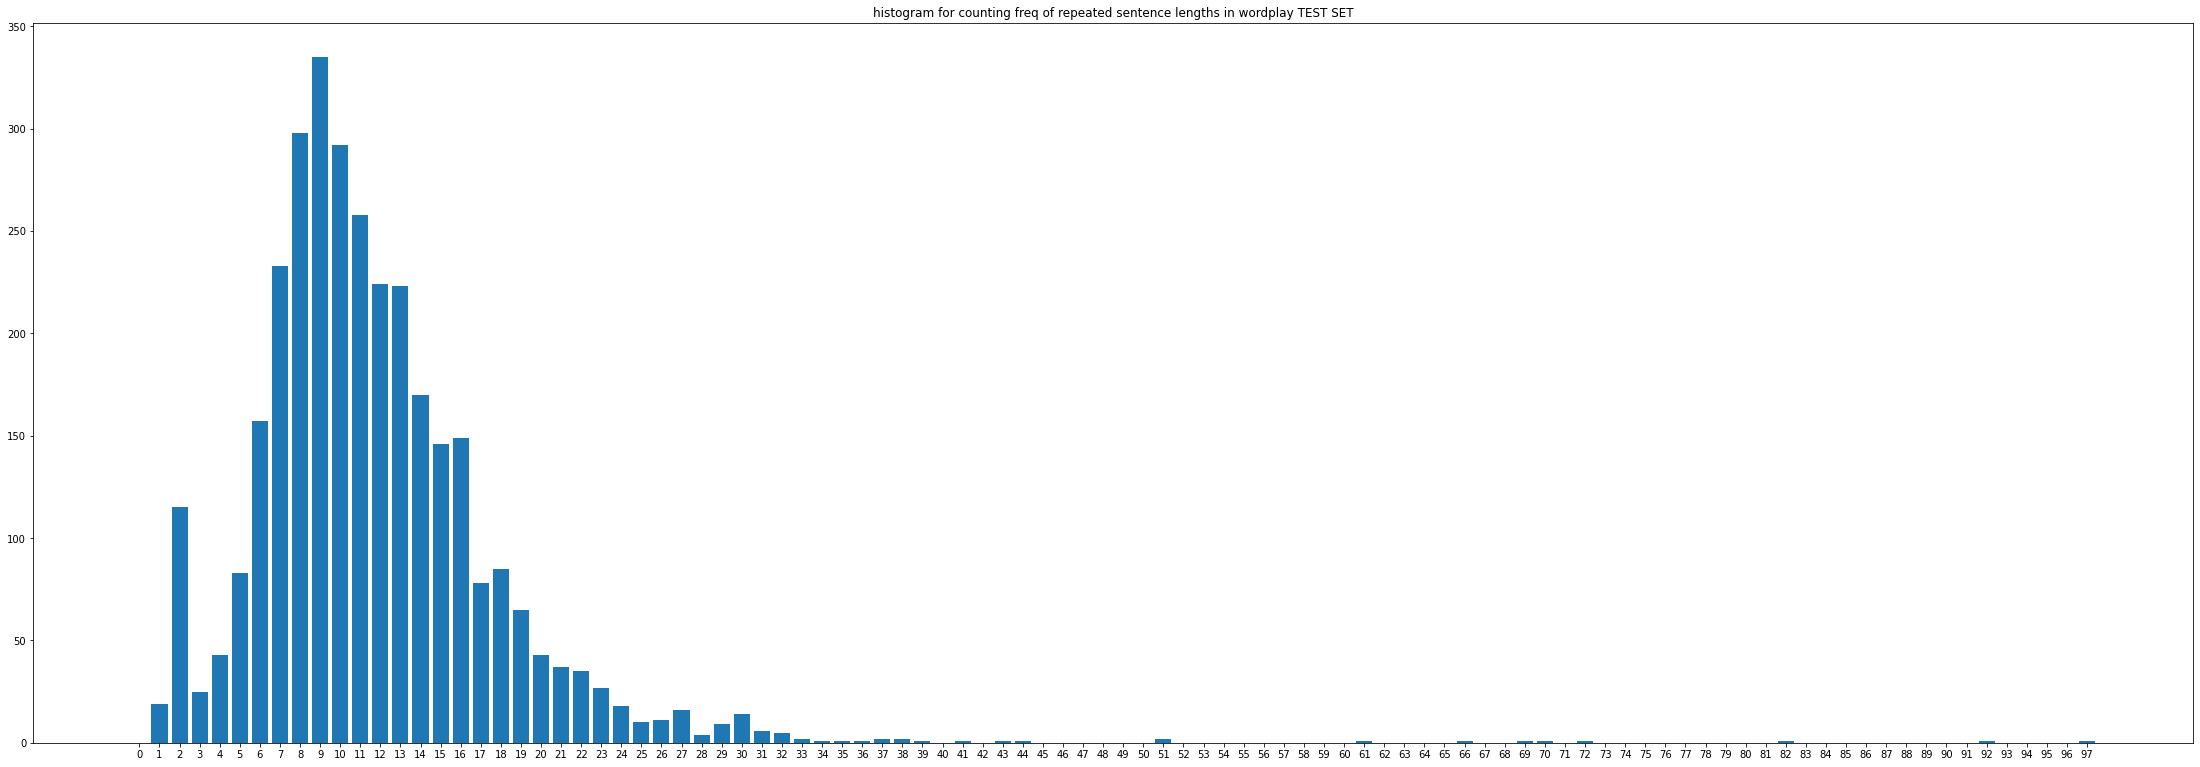

In [ ]:
'''
 ## FOR TEST DATASET:
 
 ## Finding out value of WORDPLAY variable with the maximum length in the given testing dataset.
 ## Finding out value of WORDPLAY variable with the minimum length in the given testing dataset.
 ## Visually compare length of WORDPLAY variable in the given testing dataset.

'''

num_of_words_in_wordplay = word_len(data_set_test_1['WORDPLAY'])
print("Length of Max sentence in WORDPLAY in TEST SET: ", max(num_of_words_in_wordplay))
print("Length of Min sentence in WORDPLAY in TEST SET: ", min(num_of_words_in_wordplay))

unique, counts = np.unique(num_of_words_in_wordplay, return_counts=True)
x_axis = np.arange(0, max(num_of_words_in_wordplay)+1, 1)
y_axis = np.zeros_like(x_axis)
for uni, count in zip(unique, counts):
    y_axis[uni] = count
    
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1 = fig.add_axes([0,0,1,1])
ax1.bar([str(x) for x in x_axis],y_axis)
plt.title('histogram for counting freq of repeated sentence lengths in wordplay TEST SET')

In [ ]:
'''
 ## FOR TESTING DATASEET:
 
 ## Counting number of records where the value of worplay variable is empty in test dataset.
 ## Counting number of records where the value of wordplay variable has length less than or equal to two in train dataset.
 ## Counting number of records where the value of wordplay variable has length greater than two in train dataset.
 ## Counting total number of records in the given testing dataset.
'''

count_wordplay_is_empty = 0
count_sent_in_wordplay_len_greater_than_two = 0
count_sent_in_wordplay_len_less_than_two=0

coun_word_play_and_target_text_is_same = 0

for i, row in data_set_test_1.iterrows():
    
    if(pd.isna(row["WORDPLAY"])):
        count_wordplay_is_empty+=1
        
    elif(len(row["WORDPLAY"].split())>2):
        count_sent_in_wordplay_len_greater_than_two += 1
        
    else:
        count_sent_in_wordplay_len_less_than_two+=1
    

print("1-> number of reocrds in which wordplay is empty:", count_wordplay_is_empty)

print("2-> count of sentences in wordplays having length greater than two is [",
      count_sent_in_wordplay_len_greater_than_two, "]")

print("3-> number of total records when wordplay sentences has length less than or equal to two :", 
      count_sent_in_wordplay_len_less_than_two)

print("4-> count of total number of reecords", len(data_set_test_1))

1-> number of reocrds in which wordplay is empty: 1
2-> count of sentences in wordplays having length greater than two is [ 3122 ]
3-> number of total records when wordplay sentences has length less than or equal to two : 133
4-> count of total number of reecords 3256


## PRE-PROCESSING AND BUILDING MODELS

We will iteratively learn the mapping between wordplay and other related attributes. Lets first pre-process the training data-set to learn the mapping between wordplay and location variable.

### PRE-PROCESSING TRAINING DATA-SET TO LEARN THE MAPPING BETWEEN WORDPLAY AND LOCATION

Its important to note that we have concluded that the value of the location variable and the wordplay is same when the length of wordplay variable is less than or equal to two, while doing the [EDA](#eda-wp-and-l-together).

In [ ]:
'''
 ## Function to filter the pair of wordplay and location from the train dataset where wordplay 
    has length greater than two.

 ## INPUTS:
 ## Function takes pair of list of wordplays and locations from the training dataset
 
 ## OUTPUT:
 ## Function returns pair of list of wordplays and locations from the training dataset
 
'''
def extact_train_data(wordplays, locations):
    store_wordplays = []
    store_locations = []
    for wordplay, location in zip(wordplays[:], locations[:]):
        text = str(wordplay)
        text_len = len(text.split())
        if(text_len>2):
            store_wordplays.append(text)
            store_locations.append(location)
    return store_wordplays, store_locations

In [ ]:
'''
 ## Using the extact_train_data function to find out the records where the wordplay variable
 ## has the length greater than two and develop a mapping betweeen wordplay and location.
'''
wordplay, target_text = extact_train_data(data_set_1['WORDPLAY'], data_set_1['LOCATION'])

target_data = pd.DataFrame(list(zip(wordplay, target_text)),
                                 index = np.arange(len(target_text)),
                                 columns = ['WORDPLAY', 'LOCATION'])
target_data

,WORDPLAY,LOCATION
0,Dentists don't like a hard day at the orifice.,orifice
1,Diets are for people who are thick and tired o...,thick
2,Follow your knows.,knows
3,Two astronauts who were dating put an end to i...,space
4,Yesterday a cow saved my life - it was bovine ...,bovine
...,...,...
683,Gobber the Belch,Gobber the Belch
684,Ruffnut and Tuffnut,Ruffnut and Tuffnut
685,Grimmel the Grisly,Grimmel the Grisly
686,Ragnar the Rock,Ragnar the Rock


There are only 688 rows in the training dataset in which the length of the value of wordplay is greater than two. In our strategy we will use all the dataset irrespective of the fact that the training data clearly shows that the value of locationn and wordplay is exactly same when the length of wordplay is less than or equal to two. We are doing this for two of the following reasons.

1) To increase the size of the training dataset


2) To forcely dictate the model that the location variable will never empty and it will always be a subset of wordplay variable. Assuming that the value of wordplay variable will never be empty as the training dataset illustrates.

We will also kept aside 9% of the data for testing purpose and will use it in the end to evaluate our final model. Its important to note that the we will inlcude only those records in the test set in which the value of wordplay variable is greater than two. Because in the end we want to use our model to predict the value of location variable when the value of wordplay is greater than two. <a id='id2'></a>

In [ ]:
'''
 ## Function takes three input list of wordplays and locations and test size
 ## The function creats two pairs for lists one pairs is for training and learnning
 ## the mapping between wordplays and locations and the other pair of lists is for testing purpose.
 
 ## INPUT:
 ## list of wordplays
 ## list of locations
 ## test set size
 
 ## OUTPUT:
 ## list of wordplays for training
 ## list of wordplays for testing
 ## list of locations for training
 ## list of locations for testing
'''

def extact_train_and_test_data(wordplays, locations, test_set_size):
    train_store_wordplays = []
    train_store_locations = []
    
    test_store_wordplays = []
    test_store_locations = []
    
    count_test_size = 0
    
    for wordplay, target_text in zip(wordplays[:], locations[:]):
        text = str(wordplay)
        text_len = len(text.split())
        
        if(text_len>2 and count_test_size<test_set_size):
            
            test_store_wordplays.append(text)
            test_store_locations.append(target_text)
            count_test_size = count_test_size + 1
        else:
            train_store_wordplays.append(text)
            train_store_locations.append(target_text)
            
    return train_store_wordplays, train_store_locations, test_store_wordplays, test_store_locations

In [ ]:
'''
 ## Using the extact_train_and_test_data function to create dataframe for training our model to learn the
 ## the mapping between wordplay and the location variable. Plus to develop a testing dataframe for evaluating
 ## our final model performance
'''

train_wordplay, train_target_text, test_wordplay, test_target_text = extact_train_and_test_data(data_set_1['WORDPLAY'], 
                                                                                                data_set_1['LOCATION'],
                                                                                                int(target_data.shape[0]*9/100)+1)


learn_test_data = pd.DataFrame(list(zip(test_wordplay, test_target_text)),
                               index = np.arange(len(test_target_text)),
                               columns = ['WORDPLAY', 'LOCATION'])

learn_target_data = pd.DataFrame(list(zip(train_wordplay, train_target_text)),
                                 index = np.arange(len(train_target_text)),
                                 columns = ['WORDPLAY', 'LOCATION'])


In [ ]:
'''
 ## Contents and structure of training dataset for learning the mapping between WORDPLAY and LOCATION variable.
'''

learn_target_data

,WORDPLAY,LOCATION
0,I phoned the zoo but the lion was busy.,lion
1,"I used to do rock climbing as a youth, but I w...",boulder
2,"I used to have a fear of hurdles, but I got ov...",got over
3,I was arrested after my therapist suggested I ...,take
4,"I'd like to be a Chinese laborer, said Tom coo...",coolly
...,...,...
2010,Fireworm,Fireworm
2011,Lava-Lout,Lava-Lout
2012,Lycanwing,Lycanwing
2013,Meathead,Meathead


In [ ]:
'''
 ## Contents and structure of testing dataset for learning the mapping between WORDPLAY and LOCATION variable.
'''

learn_test_data

,WORDPLAY,LOCATION
0,Dentists don't like a hard day at the orifice.,orifice
1,Diets are for people who are thick and tired o...,thick
2,Follow your knows.,knows
3,Two astronauts who were dating put an end to i...,space
4,Yesterday a cow saved my life - it was bovine ...,bovine
...,...,...
57,Hotel owners usually have suite dreams.,suite
58,How does a card player party ? They shuffle.,shuffle
59,I couldn't figure out how to fasten my seatbel...,clicked
60,I couldn't stand to be without my legs.,stand


According to our [assumptions](#id2), which we have made while developing the training and testing dataset. We can easily map the problem of learnning the value of location variable from the given wordplay to token classification. Plus, we can easily apply all the classic models developed for token classification. Here, we have used BERT model from [hugging face comunity](https://huggingface.co/course/chapter7/2?fw=pt#token-classification) for token classification problem pre-trained for Name Entity Recognition task. In the subsequent cells we will download this model and will fine-tune on our dataset to predict the token which may belong to the location variable. <a id='id3'></a>

In [ ]:
'''
 ## Creeating ENUM for store storing the mapping between NER Feature labels
 ## and their corrsponding values used by the model
 
 ## We only need to identify the tokens which may belong to the location entity.
 ## So, we need train our model to perform classification whether the token belongs to the
 ## location entity or not.
 
 ## So, wee have only three feature labels given below to map our model into NER Task.
 
 ## 1) OTHER_TOKEN LABEL: to know that the token does not belong to the location entity
 ## 2) WORD_PLAY_TOKEN_B LABEL: to know that the token does belong to location entity and its in the beginning.
 ## 3) word_play_token_I LABEL: to know that the token does belong to location entity and its after the beginning token.
 
 ## Its important to note that for any given record example: ["I", "am", "a", "student"]
 ## The model should classify only one token as WORD_PLAY_TOKEN_B label, while multiple token can be classified as word_play_token_I label.
 ## As it is the case for the entities in the classic NER problem 
'''

class features_ner(enum.Enum):
    other_token = 0
    word_play_token_B = 1
    word_play_token_I = 2

In [ ]:
'''
 ## Function performs the pre-processing on the given input text.
 
 ## INPUT:
 ## The function takes a string of text as its input.
 
 ## OUTPUT:
 ## The function returns a processed output text with lower cased letters
'''

def clean_text(text):
    """   remove @ , # , & , convert lower case , remove lower case"""
    # as we will work on rnns it is better not to remove the stopwords
    text = text.lower() # convert all text to lower case
    text = re.sub(r"(@[a-z]*)", "<mention>", text) #remove any word start with @
    text = re.sub(r"(&[a-z;]*)", "<none>", text) #remove any word start with &
    text = re.sub(r"(#[a-z;]*)", "<hash>", text) #remove any word start with #
    text = re.sub(r"(http|https|ftp|ftps)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?", "<link>", text)#remove LINKs
    text = re.sub(r'https?://\S+', '<link>', text) # remove https? links
    text = re.sub(r"(www.[a-z.\/0-9]*)", "<link>", text)#remove LINKs
    text = re.sub(r'[^\w\s]', '', text)
    return text

Transforming the developed dataset for learning the mapping between wordplay and the location variable into the form of NER datasets by using the NER feaetures from the previous created [features_ner ENUM](#id3). 

In [ ]:
ids = []
all_tokens = []
all_ner_tags = []

for label, row in learn_target_data.iterrows():
    
    clean_word_play = clean_text(row.WORDPLAY)
    clean_target_text = clean_text(row.LOCATION)

    word_play_list = clean_word_play.split()
    target_text_list = clean_target_text.split()

    ner_tags = []

    base_search_index = 0
    length_of_wordplay = len(word_play_list)

    for t_match in target_text_list:
        for index in range(base_search_index, length_of_wordplay):
            if(word_play_list[index] == t_match):

                ner_tags.append(features_ner.word_play_token_B.value 
                                if base_search_index ==0 
                                else features_ner.word_play_token_I.value)
                base_search_index = index + 1
                break
            else:
                ner_tags.append(features_ner.other_token.value)
    
    while(base_search_index<length_of_wordplay):
        base_search_index+=1
        ner_tags.append(features_ner.other_token.value)
    
    # sanity check to ensure that the array of ner_tags
    # is not empty for any given record in the dataset
    if(not ner_tags):
        print("ner_tags were empty for record #",label)
    
    # sanity check to ensure the length of ner_tags and word_play_list is same
    # as it stays always same in all the classic NER datasets
    if(not (len(ner_tags) == len(word_play_list))):
        print("ner_tags and word_play_list were un-equal #",label)
        print(ner_tags)
        print(word_play_list)
        print(target_text_list)
        print("-------------------------")
    
    ids.append(str(index))
    all_tokens.append(word_play_list)
    all_ner_tags.append(ner_tags)
    
token_classification_data_task1 = pd.DataFrame(list(zip([], [], [])),
                                               columns = ['id', 'tokens', 'ner_tags'])
token_classification_data_task1.id = ids
token_classification_data_task1.tokens = all_tokens
token_classification_data_task1.ner_tags = all_ner_tags

ner_tags and word_play_list were un-equal # 72
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the', 'young', 'pine', 'sapling', 'was', 'admonished', 'by', 'his', 'father', 'apparently', 'hed', 'been', 'knotty']
['naughty']
-------------------------
ner_tags and word_play_list were un-equal # 100
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['a', 'good', 'hash', 'is', 'never', 'lost', 'character', 'is', 'hash', 'it', 'is', 'the', 'noblest', 'of', 'possession', 'double', 'hash']
['property']
-------------------------
ner_tags and word_play_list were un-equal # 117
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['12yearold', 'ohio', 'state', 'fan', 'grant', 'reed', 'nicknamed', 'the', 'hash', 'tumor', 'in', 'his', 'brain', 'michigan', 'then', 'he', 'hash', 'hash']
['beat']
-------------------------
ner_tags and word_play_list were un-equ

Theoratically the number of ner features and the number of tokens (words) in the given string of text (sentence) should be always same. Because it's a token classification task so every token in the given text should be associated with a ner feature. Just like the classic NER dataset for token classification such as [conll2003](https://huggingface.co/datasets/conll2003). But in the above cell we have noticed that one of sanity check was failing because the length of extracted ner features arrays did not match with the number of available tokens in the given text. The reason for this particular behaviour is our code is failing to calculate the exact position of the location value in the given wordplay. Because we are doing token by token (or word by word) comparision to extract NER features and develop the dataset for training. For example lets look at the example below.

WORDPLAY VALUE: "if you're a gardener you might call yourself aplant manager"


LOCATION VALUE: "plant"

WORDPLAY TOKENS: ['if', 'youre', 'a', 'gardener', 'you', 'might', 'call', 'yourself', 'aplant', 'manager']

LOCATION TOKENS: ['plant']

Now we know that the location value 'naughty' sementically refers to the token 'knotty' because they are semantically same in the given context. But the simple string matching or word to word comparision will fail to detect this sementic relation ship. We can use algorithms like edit distance to overcome this deficiency and create a semantic relationship between the tokens and the given pattern as provided the following cell.

In [ ]:
import operator
'''
 ## The function calculate the levenshtein distance scores for the given input text and the pattern.

 ## INPUT: 
 
 ## Takes an arrau of tokens from the string of input text
 ## Takes a input a pattern
 
 ## OUTPUT:
 
 ## returns an array of levenshtein distance scores associated with each token which 
 ## denotes the simillarity of token with the given input pattern.

'''
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

string = 'plant'
matchings = ['if', 'youre', 'a', 'gardener', 'you', 'might', 'call', 'yourself', 'aplant', 'manager']

scores = {}

for m in matchings:
    scores[m] = 1 - levenshteinDistance(string,m)
print(scores)
max(scores.items(), key=operator.itemgetter(1))[0]

{'if': -4, 'youre': -4, 'a': -3, 'gardener': -6, 'you': -4, 'might': -3, 'call': -3, 'yourself': -7, 'aplant': 0, 'manager': -5}


'aplant'

The edit distance approach is a good idea to develop a semantic relation ship between the value of location variable and the tokens of wordplay text and nicely quantise it in a numeric score. And later we can choose the token association with the maximum score. But this approach will fail when there is a tie between two or more tokens. For instance lets look at the following example.

WORDPLAY VALUE: "the young pine sapling was admonished by his father apprently hed beeen knotty"


LOCATION VALUE: "naughty"

WORDPLAY TOKENS: ['the', 'young', 'pine', 'sapling', 'was', 'admonished', 'by', 'his', 'father', 'apparently', 'hed', 'been', 'knotty']

LOCATION TOKENS: ['naughty']

In this example there is a tie between naughty <-> knotty and naughty <-> father

But an important thing to notice that in the given dataset for training there were handfull of such instances where the number of extracted ner features from the given wordplay text and the location value did not match the number of extracted tokens from the wordplay text. So, we can manually fix them as presented in the following cell.




In [ ]:
print("BEFORE")
print(learn_target_data.loc[72].LOCATION, 
      learn_target_data.loc[100].LOCATION,
      learn_target_data.loc[117].LOCATION,
      learn_target_data.loc[125].LOCATION,
      learn_target_data.loc[140].LOCATION,
      learn_target_data.loc[202].LOCATION,
      learn_target_data.loc[242].LOCATION,
      learn_target_data.loc[244].LOCATION,
      learn_target_data.loc[254].LOCATION,
      learn_target_data.loc[286].LOCATION,
      learn_target_data.loc[346].LOCATION,
      learn_target_data.loc[385].LOCATION,
      learn_target_data.loc[388].LOCATION,
      learn_target_data.loc[413].LOCATION,
      learn_target_data.loc[434].LOCATION,
      learn_target_data.loc[457].LOCATION,
      learn_target_data.loc[460].LOCATION,
      learn_target_data.loc[561].LOCATION,
      learn_target_data.loc[562].LOCATION,
      learn_target_data.loc[563].LOCATION,
      learn_target_data.loc[567].LOCATION,
      learn_target_data.loc[569].LOCATION,
      learn_target_data.loc[570].LOCATION,
      learn_target_data.loc[571].LOCATION,
      learn_target_data.loc[572].LOCATION,
      learn_target_data.loc[573].LOCATION,
      learn_target_data.loc[575].LOCATION,
      learn_target_data.loc[576].LOCATION,
      learn_target_data.loc[579].LOCATION,
      learn_target_data.loc[581].LOCATION,
      learn_target_data.loc[582].LOCATION,
      learn_target_data.loc[583].LOCATION,
      learn_target_data.loc[596].LOCATION,
      learn_target_data.loc[602].LOCATION,
     )

learn_target_data.loc[72].LOCATION =  "knotty"
learn_target_data.loc[100].LOCATION = "possession"
learn_target_data.loc[117].LOCATION = "michigan"
learn_target_data.loc[125].LOCATION = "amatch"
learn_target_data.loc[140].LOCATION = "2 fingers"
learn_target_data.loc[202].LOCATION = "take a day off"
learn_target_data.loc[242].LOCATION = "cost me an arm and a leg"
learn_target_data.loc[244].LOCATION = "aplant"
learn_target_data.loc[254].LOCATION = "fatigué"
learn_target_data.loc[286].LOCATION = "identities"
learn_target_data.loc[346].LOCATION = "saidclothedtil"
learn_target_data.loc[385].LOCATION = "jalapeño face"
learn_target_data.loc[388].LOCATION = "i dont know and i dont care"
learn_target_data.loc[413].LOCATION = "koalafication"
learn_target_data.loc[434].LOCATION = "bar"
learn_target_data.loc[457].LOCATION = "toad"
learn_target_data.loc[460].LOCATION = "comet"
learn_target_data.loc[561].LOCATION = "2 fingers"
learn_target_data.loc[562].LOCATION = "spread it"
learn_target_data.loc[563].LOCATION = "chicken"
learn_target_data.loc[567].LOCATION = "isnt talking to me"
learn_target_data.loc[569].LOCATION = "angel dust"
learn_target_data.loc[570].LOCATION = "gaily"
learn_target_data.loc[571].LOCATION = "stag"
learn_target_data.loc[572].LOCATION = "top"
learn_target_data.loc[573].LOCATION = "bright"
learn_target_data.loc[575].LOCATION = "gave a lot away"
learn_target_data.loc[576].LOCATION = "six feet under"
learn_target_data.loc[579].LOCATION = "crowning achievement"
learn_target_data.loc[581].LOCATION = "thefissure king"
learn_target_data.loc[582].LOCATION = "whys"
learn_target_data.loc[583].LOCATION = "cougher"
learn_target_data.loc[596].LOCATION = "chicken"
learn_target_data.loc[602].LOCATION = "fuse"

print("AFTER")
print(learn_target_data.loc[72].LOCATION, 
      learn_target_data.loc[100].LOCATION,
      learn_target_data.loc[117].LOCATION,
      learn_target_data.loc[125].LOCATION,
      learn_target_data.loc[140].LOCATION,
      learn_target_data.loc[202].LOCATION,
      learn_target_data.loc[242].LOCATION,
      learn_target_data.loc[244].LOCATION,
      learn_target_data.loc[254].LOCATION,
      learn_target_data.loc[286].LOCATION,
      learn_target_data.loc[346].LOCATION,
      learn_target_data.loc[385].LOCATION,
      learn_target_data.loc[388].LOCATION,
      learn_target_data.loc[413].LOCATION,
      learn_target_data.loc[434].LOCATION,
      learn_target_data.loc[457].LOCATION,
      learn_target_data.loc[460].LOCATION,
      learn_target_data.loc[561].LOCATION,
      learn_target_data.loc[562].LOCATION,
      learn_target_data.loc[563].LOCATION,
      learn_target_data.loc[567].LOCATION,
      learn_target_data.loc[569].LOCATION,
      learn_target_data.loc[570].LOCATION,
      learn_target_data.loc[571].LOCATION,
      learn_target_data.loc[572].LOCATION,
      learn_target_data.loc[573].LOCATION,
      learn_target_data.loc[575].LOCATION,
      learn_target_data.loc[576].LOCATION,
      learn_target_data.loc[579].LOCATION,
      learn_target_data.loc[581].LOCATION,
      learn_target_data.loc[582].LOCATION,
      learn_target_data.loc[583].LOCATION,
      learn_target_data.loc[596].LOCATION,
      learn_target_data.loc[602].LOCATION,
     )

BEFORE
naughty property beat match two fingers took a day off it costs an arm and leg plant tired identity clothed jalapenõ face [0] koalification maine toad/tow no comet no comet yammered blow up jester iris Marx bat tee tee coached shots vinyl fissure mow throng fowl soar
AFTER
knotty possession michigan amatch 2 fingers take a day off cost me an arm and a leg aplant fatigué identities saidclothedtil jalapeño face i dont know and i dont care koalafication bar toad comet 2 fingers spread it chicken isnt talking to me angel dust gaily stag top bright gave a lot away six feet under crowning achievement thefissure king whys cougher chicken fuse


Now after fixing some of the records, we will again try to transform the developed dataset for learning the mapping between wordplay and the location variable into the form of NER datasets by using the NER feaetures from the previous created [features_ner ENUM](#id3). 

In [ ]:
ids = []
all_tokens = []
all_ner_tags = []

for label, row in learn_target_data.iterrows():
    
    clean_word_play = clean_text(row.WORDPLAY)
    clean_target_text = clean_text(row.LOCATION)

    word_play_list = clean_word_play.split()
    target_text_list = clean_target_text.split()

    ner_tags = []

    base_search_index = 0
    length_of_wordplay = len(word_play_list)

    for t_match in target_text_list:
        for index in range(base_search_index, length_of_wordplay):
            if(word_play_list[index] == t_match):

                ner_tags.append(features_ner.word_play_token_B.value 
                                if base_search_index ==0 
                                else features_ner.word_play_token_I.value)
                base_search_index = index + 1
                break
            else:
                ner_tags.append(features_ner.other_token.value)
    
    while(base_search_index<length_of_wordplay):
        base_search_index+=1
        ner_tags.append(features_ner.other_token.value)
    
    # sanity check
    if(not ner_tags):
        print("ner_tags were empty for record #",label)
    
    # sanity check
    if(not (len(ner_tags) == len(word_play_list))):
        print("ner_tags and word_play_list were un-equal #",label)
        print(ner_tags)
        print(word_play_list)
        print(target_text_list)
        print("-------------------------")
    
    ids.append(str(index))
    all_tokens.append(word_play_list)
    all_ner_tags.append(ner_tags)
    
token_classification_data_task1 = pd.DataFrame(list(zip([], [], [])),
                                               columns = ['id', 'tokens', 'ner_tags'])
token_classification_data_task1.id = ids
token_classification_data_task1.tokens = all_tokens
token_classification_data_task1.ner_tags = all_ner_tags

The dataset is ready now and we have successfully transformed it into a classifical dataset for token classifcation. The next thing is just to seprate the training and validation records and convert the dataframe into a Dataset Dictionary so that hugging face models can operate on it easily.

In [ ]:
train_task1, val_task1 = train_test_split(token_classification_data_task1, test_size=0.4)

class_names_ner_tags = [features_ner.other_token.name,
                        features_ner.word_play_token_B.name,
                        features_ner.word_play_token_I.name]

ft = Features({
    'id': Value(dtype='string', id=None),
    'tokens': Sequence(Value("string")),
    'ner_tags': Sequence(
        feature= ClassLabel(
            num_classes=len(class_names_ner_tags),
            names=class_names_ner_tags,id=None),
        length=-1, id=None)

})

train_dataset_1 = Dataset.from_pandas(train_task1, features=ft, split='train+test')

val_datasets_1 = Dataset.from_pandas(val_task1, features=ft, split='train+test')

raw_datasets = DatasetDict({
    "train":train_dataset_1,
    "validation": val_datasets_1
})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1209
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 806
    })
})

In [ ]:
'''
 ## Exploring the developed Dataset Dictionary for the training.
'''

print("First Training EG: ", raw_datasets["train"][0]["tokens"])
print("NER TAGS for First Training EG: ",raw_datasets["train"][0]["ner_tags"])

ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names

print("\nNER FEATURES of the dataset: ", ner_feature)
print("\nLABEL NAMES for NER FEATURES: ", label_names)


print("\nEXAMPLE DECODING FOR THE FIRST TRAINING RECORD")
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]

for word, label in zip(words, labels):
    full_label = label_names[label]
    print(word," - " ,full_label, "\n")

First Training EG:  ['deino']
NER TAGS for First Training EG:  [1]

NER FEATURES of the dataset:  Sequence(feature=ClassLabel(num_classes=3, names=['other_token', 'word_play_token_B', 'word_play_token_I'], id=None), length=-1, id=None)

LABEL NAMES for NER FEATURES:  ['other_token', 'word_play_token_B', 'word_play_token_I']

EXAMPLE DECODING FOR THE FIRST TRAINING RECORD
deino  -  word_play_token_B 



### MODEL PREPARATION TO LEARN THE MAPPING BETWEEN WORDPLAY AND LOCATION

We have selected [bert-base-cased](https://huggingface.co/bert-base-cased) model from hugging face repository to perform the token classification for our LOCATION entity.

In [ ]:
'''
 ## Setuping the pre-trained "bert-base-cased" from the hugging face repository.
'''
model_checkpoint = "bert-base-cased" if (download_bert_token_classification_for_location_extraction) else base_path + 'models/bert-base-cased'
tokenizer_for_location = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
'''
 ## Checking the working of bert-base-cased toknizer on an example record from the developed dataset dictionary for training
'''

inputs = tokenizer_for_location(raw_datasets["train"][1]["tokens"], is_split_into_words=True)
print("ACTUAL TOKENS: ", raw_datasets["train"][1]["tokens"])
print("TOKINZED TOKENS: ", inputs.tokens())
print("TOKENIZED WORD IDS: ",inputs.word_ids())

ACTUAL TOKENS:  ['munchlax']
TOKINZED TOKENS:  ['[CLS]', 'm', '##unch', '##lax', '[SEP]']
TOKENIZED WORD IDS:  [None, 0, 0, 0, None]


The output of above cells illustrates that the tokenizer can do further chunking in any particular token present in the list of actual wordplay tokens. Plus, the tokenizer also appends and pre-pends some meta-tokens (like [CLS] and [SEP]) for the tracking the beginning and ending of the word play text. For instance consider the following example:

WORDPLAY TEXT: earwigs

ACTUAL TOKENS:  ['earwigs']

TOKINZED TOKENS:  ['[CLS]', 'ear', '##wig', '##s', '[SEP]']

TOKENIZED WORD IDS:  [None, 0, 0, 0, None]

So, we need some kind alignment function to accomodate for meta-tokens and sub-divided chunks by the tokenizers.

In [ ]:
'''
 ## The function takes two arrays as its input. The fist array contains ner featuer labels for a corresponding 
 ## wordplay text from the prepared dataset dic for training and the other array contains tokenized representation
 ## of wordplay tokens.  The function creates aligned the two array by appending and prepending -100 for [CLS] and 
 ## [SEP] tokens and assigning appropriate ner feature label to the toknized chuncks of the particular token.
 
 ## INPUTS:
 ## Array of actual NER feeature labels from the training dataset.
 ## Array of word ids generated from the tokenizers.
 
 ## OUTPUTS:
 ## properly aligned new labels
'''
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
   
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
         
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


inputs = tokenizer_for_location(raw_datasets["train"][1]["tokens"], is_split_into_words=True)
word_ids = inputs.word_ids()
labels = raw_datasets["train"][1]["ner_tags"]


print("ACTUAL TOKENS: ", raw_datasets["train"][1]["tokens"])
print("ACTUAL LABELS: ", labels)
print("TOKINZED TOKENS: ", inputs.tokens())
print("TOKENIZED WORD IDS: ",inputs.word_ids())
print("ALIGNED LABELS: ", align_labels_with_tokens(labels, word_ids))

ACTUAL TOKENS:  ['munchlax']
ACTUAL LABELS:  [1]
TOKINZED TOKENS:  ['[CLS]', 'm', '##unch', '##lax', '[SEP]']
TOKENIZED WORD IDS:  [None, 0, 0, 0, None]
ALIGNED LABELS:  [-100, 1, 2, 2, -100]


Next we will just tokenize the whole data-set using the downloaded tokenizer [bert-base-cased](https://huggingface.co/bert-base-cased) from hugging face repository and produce newly aligned ner_feature labels array.

In [ ]:
'''
 ## The function accepts a record from the training Dataset-Dict and tokenize them using the
 ## bert-base-cased tokenizer. Plus it also generates a new array of ner-features aligned with
 ## the tokenized output generated by the bert-base-cased tokenizer
 
 ## INPUT:
 ## A record from the previously developed training Dataset-Dict
 
 ## OUTPUT:
 ## A tokenized copy of the input record
'''
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_for_location(
        examples["tokens"], is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
'''
 ## Toknized entire training Dataset-Dict
'''

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
'''
 ## Dividing the developed tokenized dataset into number of batches
 ## and creating a data loader for both training an validation set.
'''

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_for_location)
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

Next, we will load the bert-base-cased model and pass it a dictionary for ner_feature label names and their corresponding id vice a versa.

In [ ]:
'''
 ## Loading the bert-base-cased model
'''

id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
model_for_location = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Next, we will load the Adam optimizer and initiate the Accelerator library.

In [ ]:
'''
 ## Loading the Adam optimizer and preparing the Accelerator instance to initiate the training.
'''
optimizer = AdamW(model_for_location.parameters(), lr=2e-5)
accelerator = Accelerator()
model_for_location, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model_for_location, optimizer, train_dataloader, eval_dataloader
)


In [ ]:
'''
 ## We have utillized a linear scheduler for our training and defined few hyper-parameters below.
'''

num_train_epochs = 20
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
'''
 ## The function takes two inputs tokenized predictions and the corresponding ner feature
 ## labels and convert them back into the orignal untokenized form.
'''
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_labels, true_predictions

Lastly we will define the training loop and fine-tune our model on the prepared dataset.

In [ ]:
metric = load_metric("seqeval")
output_dir = base_path+"/dataset/JOKER/Task 1/train/FT_Model/bert-finetuned-ner-location-JOKER_task1"

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model_for_location.train()
    for batch in train_dataloader:
        outputs = model_for_location(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model_for_location.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model_for_location(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model_for_location)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer_for_location.save_pretrained(output_dir)

  5%|▌         | 152/3040 [00:11<03:44, 12.87it/s]/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: word_play_token_B seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: word_play_token_I seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other_token seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


epoch 0: {'precision': 0.7687736358725014, 'recall': 0.8321637426900584, 'f1': 0.799213704015726, 'accuracy': 0.9436028472348968}


 10%|█         | 304/3040 [00:25<03:25, 13.29it/s]

epoch 1: {'precision': 0.8357644516477579, 'recall': 0.819385593220339, 'f1': 0.8274939823482215, 'accuracy': 0.9446979375798503}


 15%|█▌        | 456/3040 [00:40<03:13, 13.38it/s]

epoch 2: {'precision': 0.8519719070772556, 'recall': 0.8469387755102041, 'f1': 0.8494478858066254, 'accuracy': 0.9554663259718926}


 20%|██        | 608/3040 [00:55<02:55, 13.88it/s]

epoch 3: {'precision': 0.8622366288492707, 'recall': 0.8417721518987342, 'f1': 0.8518815052041633, 'accuracy': 0.9563789012593539}


 25%|██▌       | 760/3040 [01:10<02:49, 13.48it/s]

epoch 4: {'precision': 0.8508914100486223, 'recall': 0.8472296933835395, 'f1': 0.8490566037735848, 'accuracy': 0.9552838109144004}


 30%|███       | 912/3040 [01:24<02:38, 13.43it/s]

epoch 5: {'precision': 0.86709886547812, 'recall': 0.8514588859416445, 'f1': 0.8592077087794433, 'accuracy': 0.9578390217192918}


 35%|███▌      | 1064/3040 [01:40<02:24, 13.65it/s]

epoch 6: {'precision': 0.8595353862776878, 'recall': 0.8656147986942329, 'f1': 0.8625643805909461, 'accuracy': 0.9589341120642453}


 40%|████      | 1216/3040 [01:55<02:15, 13.47it/s]

epoch 7: {'precision': 0.8616963803349541, 'recall': 0.8654367878459034, 'f1': 0.8635625338386572, 'accuracy': 0.9596641722942143}


 45%|████▍     | 1367/3040 [02:10<02:04, 13.48it/s]

epoch 8: {'precision': 0.8622366288492707, 'recall': 0.8669201520912547, 'f1': 0.8645720476706393, 'accuracy': 0.9598466873517065}


 50%|████▉     | 1519/3040 [02:25<01:50, 13.79it/s]

epoch 9: {'precision': 0.8584548892490546, 'recall': 0.8678317859093392, 'f1': 0.8631178707224335, 'accuracy': 0.9589341120642453}


 55%|█████▍    | 1671/3040 [02:40<01:41, 13.45it/s]

epoch 10: {'precision': 0.8584548892490546, 'recall': 0.8725974739154311, 'f1': 0.8654684095860566, 'accuracy': 0.9592991421792297}


 60%|██████    | 1824/3040 [02:55<01:28, 13.77it/s]

epoch 11: {'precision': 0.8779038357644516, 'recall': 0.8602435150873478, 'f1': 0.8689839572192514, 'accuracy': 0.9613068078116445}


 65%|██████▌   | 1976/3040 [03:10<01:20, 13.28it/s]

epoch 12: {'precision': 0.8768233387358185, 'recall': 0.8587301587301587, 'f1': 0.867682437850842, 'accuracy': 0.9613068078116445}


 70%|███████   | 2128/3040 [03:24<01:04, 14.23it/s]

epoch 13: {'precision': 0.8746623446785521, 'recall': 0.8584305408271474, 'f1': 0.8664704308268665, 'accuracy': 0.96094177769666}


 75%|███████▌  | 2280/3040 [03:41<01:00, 12.56it/s]

epoch 14: {'precision': 0.8681793625067531, 'recall': 0.8700595560368165, 'f1': 0.869118442401298, 'accuracy': 0.9611242927541522}


 80%|████████  | 2432/3040 [03:56<00:45, 13.47it/s]

epoch 15: {'precision': 0.8757428417071853, 'recall': 0.8558606124604012, 'f1': 0.8656875834445928, 'accuracy': 0.9607592626391678}


 85%|████████▌ | 2584/3040 [04:11<00:34, 13.03it/s]

epoch 16: {'precision': 0.8714208535926526, 'recall': 0.8723634396971336, 'f1': 0.8718918918918919, 'accuracy': 0.9622193830991057}


 90%|█████████ | 2736/3040 [04:26<00:22, 13.67it/s]

epoch 17: {'precision': 0.8703403565640194, 'recall': 0.8679956896551724, 'f1': 0.8691664418667385, 'accuracy': 0.9618543529841211}


 95%|█████████▌| 2888/3040 [04:41<00:11, 13.72it/s]

epoch 18: {'precision': 0.8698001080497029, 'recall': 0.8735756918068367, 'f1': 0.8716838115863562, 'accuracy': 0.9618543529841211}


100%|██████████| 3040/3040 [04:57<00:00, 13.52it/s]

epoch 19: {'precision': 0.8714208535926526, 'recall': 0.873308067135896, 'f1': 0.8723634396971335, 'accuracy': 0.9624018981565979}


Checking models output on an example record from the previously created [test dataframe](#id2).

In [ ]:
index = 2
token_classifier_for_location = pipeline(
    "token-classification", model=output_dir, aggregation_strategy="simple"
)
preds = token_classifier_for_location(clean_text(learn_test_data.loc[index].WORDPLAY))

print(clean_text(learn_test_data.loc[index].WORDPLAY), ":", clean_text(learn_test_data.loc[index].LOCATION))
preds

follow your knows : knows


[{'entity_group': 'other_token',
  'score': 0.9407253,
  'word': 'follow your',
  'start': 0,
  'end': 11},
 {'entity_group': 'word_play_token_B',
  'score': 0.9968265,
  'word': 'knows',
  'start': 12,
  'end': 17}]

Below, we have evaluated the fine-tuned model on the previously created [test dataframe](#id2) to validate the model performance on the un-seen data.

In [ ]:
perfect_matches = 0
hash_counts = 2
for index, row in learn_test_data.iterrows():
    input_text = clean_text(row.WORDPLAY)
    target_text = clean_text(row.LOCATION)
    
    preds = token_classifier_for_location(input_text)
    prediction_text = ""
    
    for pred in preds:
        if((pred["entity_group"] == "word_play_token_B") or (pred["entity_group"] == "word_play_token_I")):
            pred_word = pred["word"]
            prediction_text +=  (pred_word[hash_counts:] if pred_word.startswith("#"*hash_counts) else (" "+pred_word))
    
    prediction_text = prediction_text.strip()
    is_matched = target_text == prediction_text
    if(is_matched):
        perfect_matches +=1
    
    print("TARGET TEXT: ", target_text, " PREDICTED TEXT: ", prediction_text, " IS MATCHED: ", (is_matched) )
print("TOTAL MATCHED: ", perfect_matches, " OUT OF: ", len(learn_test_data))

TARGET TEXT:  orifice  PREDICTED TEXT:  orifice  IS MATCHED:  True
TARGET TEXT:  thick  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  knows  PREDICTED TEXT:  knows  IS MATCHED:  True
TARGET TEXT:  space  PREDICTED TEXT:  space  IS MATCHED:  True
TARGET TEXT:  bovine  PREDICTED TEXT:  bovine  IS MATCHED:  True
TARGET TEXT:  patch  PREDICTED TEXT:  pumpkin  IS MATCHED:  False
TARGET TEXT:  on the house  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  feyonce  PREDICTED TEXT:  feyonce  IS MATCHED:  True
TARGET TEXT:  changing  PREDICTED TEXT:  changing  IS MATCHED:  True
TARGET TEXT:  remote  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  twister  PREDICTED TEXT:  twister  IS MATCHED:  True
TARGET TEXT:  vowel  PREDICTED TEXT:  vowel  IS MATCHED:  True
TARGET TEXT:  call me  PREDICTED TEXT:  taxi  IS MATCHED:  False
TARGET TEXT:  piously  PREDICTED TEXT:  3 piously  IS MATCHED:  False
TARGET TEXT:  diplomatically  PREDICTED TEXT:  diplomatically  IS MATCHED:  True
TARGET TE

There is a small optimization which we can do in while gathering the predictions from the model. Its important to note that the model preserves the orginal order of the wordplay text while emitting its prediction. We can iduce the sanity check to ensure that if a token is sub-divided into small chunks then if their head is classified as location entity then all chunks that belongs to that token will eventually get grouped in the same category.

In [ ]:
perfect_matches = 0
hash_counts = 2
number_of_empty_preds = 0
len_greater_than_two = 0

for index, row in learn_test_data.iterrows():
    input_text = clean_text(row.WORDPLAY)
    target_text = clean_text(row.LOCATION)
    
    preds = token_classifier_for_location(input_text)
    prediction_text = ""
    begin = False
    
    for pred in preds:
        if((pred["entity_group"] == "word_play_token_B")):
            pred_word = pred["word"]
            prediction_text +=  (pred_word[hash_counts:]) if pred_word.startswith("#"*hash_counts) else (" "+pred_word)
            begin= True
        
        elif(pred["entity_group"] == "word_play_token_I"):
            pred_word = pred["word"]
            prediction_text +=  ((pred_word[hash_counts:]) if pred_word.startswith("#"*hash_counts) else (" "+pred_word))
            begin = False
        
        elif(begin and  pred["word"].startswith("#"*hash_counts)):
            pred_word = pred["word"]
            prediction_text += (pred_word[hash_counts:]) if pred_word.startswith("#"*hash_counts) else (" "+pred_word)
            
        else:
            begin = False
        
    
    prediction_text = prediction_text.strip()
    is_matched = target_text == prediction_text
    if(is_matched):
        perfect_matches +=1
        
    # sanity check
    if(not prediction_text):
        number_of_empty_preds +=1
        if(len(input_text)):
            len_greater_than_two+=1
        
    print("TARGET TEXT: ", target_text, " PREDICTED TEXT: ", prediction_text, " IS MATCHED: ", (is_matched) )
print("TOTAL MATCHED: ", perfect_matches, " OUT OF: ", len(learn_test_data), "Number of empty prediction: ", number_of_empty_preds, "when ", len_greater_than_two, "# input texts have length greater than two")


TARGET TEXT:  orifice  PREDICTED TEXT:  orifice  IS MATCHED:  True
TARGET TEXT:  thick  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  knows  PREDICTED TEXT:  knows  IS MATCHED:  True
TARGET TEXT:  space  PREDICTED TEXT:  space  IS MATCHED:  True
TARGET TEXT:  bovine  PREDICTED TEXT:  bovine  IS MATCHED:  True
TARGET TEXT:  patch  PREDICTED TEXT:  pumpkin  IS MATCHED:  False
TARGET TEXT:  on the house  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  feyonce  PREDICTED TEXT:  feyonce  IS MATCHED:  True
TARGET TEXT:  changing  PREDICTED TEXT:  changing  IS MATCHED:  True
TARGET TEXT:  remote  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  twister  PREDICTED TEXT:  twister  IS MATCHED:  True
TARGET TEXT:  vowel  PREDICTED TEXT:  vowel  IS MATCHED:  True
TARGET TEXT:  call me  PREDICTED TEXT:  taxi  IS MATCHED:  False
TARGET TEXT:  piously  PREDICTED TEXT:  3 piously  IS MATCHED:  False
TARGET TEXT:  diplomatically  PREDICTED TEXT:  diplomatically  IS MATCHED:  True
TARGET TE

100%|██████████| 3040/3040 [05:10<00:00, 13.52it/s]

TARGET TEXT:  sagely  PREDICTED TEXT:  sagely  IS MATCHED:  True
TARGET TEXT:  punctually  PREDICTED TEXT:  punctually  IS MATCHED:  True
TARGET TEXT:  upheld  PREDICTED TEXT:  collapsetom upheld  IS MATCHED:  False
TARGET TEXT:  easily  PREDICTED TEXT:  easily  IS MATCHED:  True
TARGET TEXT:  grimly  PREDICTED TEXT:  grimly  IS MATCHED:  True
TARGET TEXT:  coached  PREDICTED TEXT:    IS MATCHED:  False
TARGET TEXT:  glowingly  PREDICTED TEXT:  glowingly  IS MATCHED:  True
TARGET TEXT:  quiveringly  PREDICTED TEXT:  quiveringly  IS MATCHED:  True
TARGET TEXT:  fruitlessly  PREDICTED TEXT:  fruitlessly  IS MATCHED:  True
TARGET TEXT:  caustically  PREDICTED TEXT:  caustically  IS MATCHED:  True
TARGET TEXT:  deep  PREDICTED TEXT:  deep  IS MATCHED:  True
TARGET TEXT:  entrenched  PREDICTED TEXT:  entrenched  IS MATCHED:  True
TARGET TEXT:  cymbalize  PREDICTED TEXT:  cymbalize  IS MATCHED:  True
TARGET TEXT:  yeast  PREDICTED TEXT:  yeast  IS MATCHED:  True
TARGET TEXT:  varnish  PREDIC

We can also easily apply the [KeyBert Model](https://maartengr.github.io/KeyBERT/) on the [test dataframe](#id2). To demonstrate the working of the idea we can use pre-trained 'all-MiniLM-L6-v2' model with the KeyBert mechanism.

In [ ]:
kw_model_for_location = KeyBERT(model ='all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
perfect_matches = 0
for index, row in learn_test_data.iterrows():
    input_text = clean_text(row.WORDPLAY)
    target_text = clean_text(row.LOCATION)
    
    keywords = kw_model_for_location.extract_keywords(input_text, keyphrase_ngram_range=(1, 1), stop_words=None)
    prediction_text = max(keywords, key = lambda k : k[1])[0]

    prediction_text = prediction_text.strip()
    is_matched = target_text == prediction_text
    if(is_matched):
        perfect_matches +=1
    
    print("TARGET TEXT: ", target_text, " PREDICTED TEXT: ", prediction_text, " IS MATCHED: ", (is_matched) )
print("TOTAL MATCHED: ", perfect_matches, " OUT OF: ", len(learn_test_data))

TARGET TEXT:  orifice  PREDICTED TEXT:  dentists  IS MATCHED:  False
TARGET TEXT:  thick  PREDICTED TEXT:  diets  IS MATCHED:  False
TARGET TEXT:  knows  PREDICTED TEXT:  follow  IS MATCHED:  False
TARGET TEXT:  space  PREDICTED TEXT:  astronauts  IS MATCHED:  False
TARGET TEXT:  bovine  PREDICTED TEXT:  bovine  IS MATCHED:  True
TARGET TEXT:  patch  PREDICTED TEXT:  pumpkin  IS MATCHED:  False
TARGET TEXT:  on the house  PREDICTED TEXT:  chimney  IS MATCHED:  False
TARGET TEXT:  feyonce  PREDICTED TEXT:  jayz  IS MATCHED:  False
TARGET TEXT:  changing  PREDICTED TEXT:  red  IS MATCHED:  False
TARGET TEXT:  remote  PREDICTED TEXT:  island  IS MATCHED:  False
TARGET TEXT:  twister  PREDICTED TEXT:  twister  IS MATCHED:  True
TARGET TEXT:  vowel  PREDICTED TEXT:  vowel  IS MATCHED:  True
TARGET TEXT:  call me  PREDICTED TEXT:  taxi  IS MATCHED:  False
TARGET TEXT:  piously  PREDICTED TEXT:  14159265tom  IS MATCHED:  False
TARGET TEXT:  diplomatically  PREDICTED TEXT:  tom  IS MATCHED:  F

In the last, we can also used the fine-tuned bert-base-cased model with the KeyBert model. The fine-tuned bert-base-cased model will generates the embedding for the given input wordplay text and the KeyBert model will utillize those embeddings to further drill down the most simillar n-gram for the wordplay.

In [ ]:
class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model, embedding_tokenizer):
        super().__init__()
        self.embedding_model = embedding_model
        self.embedding_tokenizer = embedding_tokenizer

    def embed(self, documents, verbose=False):
        encoded_inputs = self.embedding_tokenizer(documents, return_tensors='pt', padding=True)
        output = self.embedding_model(**encoded_inputs)
        embeddings = output[1].cpu().detach().numpy()
        return embeddings 


embed_tokenizer = BertTokenizer.from_pretrained(output_dir)
embed_model = BertModel.from_pretrained(output_dir, output_hidden_states = True)


custom_embedder = CustomEmbedder(embedding_model=embed_model, embedding_tokenizer=embed_tokenizer)
kw_custom_model = KeyBERT(model=custom_embedder)

perfect_matches = 0
for index, row in learn_test_data.iterrows():
    input_text = clean_text(row.WORDPLAY)
    target_text = clean_text(row.LOCATION)
    
    keywords = kw_custom_model.extract_keywords(input_text, keyphrase_ngram_range=(1, 1), stop_words=None)
    prediction_text = max(keywords, key = lambda k : k[1])[0] if (len(keywords)>0) else ""

    prediction_text = prediction_text.strip()
    is_matched = target_text == prediction_text
    if(is_matched):
        perfect_matches +=1
    
    print("TARGET TEXT: ", target_text, " PREDICTED TEXT: ", prediction_text, " IS MATCHED: ", (is_matched) )
print("TOTAL MATCHED: ", perfect_matches, " OUT OF: ", len(learn_test_data))

Some weights of the model checkpoint at /content/drive/My Drive//dataset/JOKER/Task 1/train/FT_Model/bert-finetuned-ner-location-JOKER_task1 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive//dataset/JOKER/Task 1/train/FT_Model/bert-finetuned-ner-location-JOKER_task1 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

TARGET TEXT:  orifice  PREDICTED TEXT:  day  IS MATCHED:  False
TARGET TEXT:  thick  PREDICTED TEXT:  are  IS MATCHED:  False
TARGET TEXT:  knows  PREDICTED TEXT:  follow  IS MATCHED:  False
TARGET TEXT:  space  PREDICTED TEXT:  because  IS MATCHED:  False
TARGET TEXT:  bovine  PREDICTED TEXT:  yesterday  IS MATCHED:  False
TARGET TEXT:  patch  PREDICTED TEXT:  do  IS MATCHED:  False
TARGET TEXT:  on the house  PREDICTED TEXT:  hash  IS MATCHED:  False
TARGET TEXT:  feyonce  PREDICTED TEXT:  did  IS MATCHED:  False
TARGET TEXT:  changing  PREDICTED TEXT:  look  IS MATCHED:  False
TARGET TEXT:  remote  PREDICTED TEXT:  belongs  IS MATCHED:  False
TARGET TEXT:  twister  PREDICTED TEXT:  is  IS MATCHED:  False
TARGET TEXT:  vowel  PREDICTED TEXT:  come  IS MATCHED:  False
TARGET TEXT:  call me  PREDICTED TEXT:  me  IS MATCHED:  False
TARGET TEXT:  piously  PREDICTED TEXT:  14159265tom  IS MATCHED:  False
TARGET TEXT:  diplomatically  PREDICTED TEXT:  you  IS MATCHED:  False
TARGET TEXT:  

### PRE-PROCESSING TRAINING DATA-SET TO LEARN THE MAPPING BETWEEN WORDPLAY AND MANIPULATION_TYPE

First lets re-check the distinct values present in the MANIPULATION_TYPE column of the given training data

In [ ]:
'''
 ## Listing all unique values in the MANIPULATION_TYPE column
'''

data_set_1.MANIPULATION_TYPE.unique()

array(['Similarity', 'Identity', 'Permutation', 'Abbreviation', None,
       '[0]'], dtype=object)

In [ ]:
'''
 ## Creating an ENUM for the unique values present in the MANIPULATION_TYPE column 
'''

class class_names_manipulation_type(enum.Enum):
    Similarity = 0
    Identity = 1
    Permutation = 2
    Abbreviation = 3

Next, we will develop a sub-set of the given training data-set for learning the mapping between wordplay and manipulation type. And filter out those records for which the correct label does not exist, that is the value of the manipulation type is either **None** or equal to **[0]**

In [ ]:
'''
 ## Creating new dataframe which has only two columns wordplay and manipulation type label from the given 
 ## training dataset. Plus, filtering records for which the correct label for manipulation type does not exist.
'''
data_for_manipulation_type_wordplay = []
data_for_manipulation_type_category = []
selected_records = 0
ids = []

for index, row in data_set_1.iterrows():
    wordplay = clean_text(row.WORDPLAY)
    class_label = -1
    if(row.MANIPULATION_TYPE == class_names_manipulation_type.Similarity.name):
        class_label = class_names_manipulation_type.Similarity.value
    
    elif(row.MANIPULATION_TYPE == class_names_manipulation_type.Identity.name):
        class_label = class_names_manipulation_type.Identity.value
    
    elif(row.MANIPULATION_TYPE == class_names_manipulation_type.Permutation.name):
        class_label = class_names_manipulation_type.Permutation.value
    
    elif(row.MANIPULATION_TYPE == class_names_manipulation_type.Abbreviation.name):
        class_label = class_names_manipulation_type.Abbreviation.value
    
    # for sanity
    if(class_label == -1):
        print("class label is -1 for index: ", index)
    else:
        ids.append(str(selected_records))
        data_for_manipulation_type_wordplay.append(wordplay)
        data_for_manipulation_type_category.append(class_label)
        
        selected_records +=1
        
print("Number of ignored records is: ", len(data_set_1) - selected_records, " out of total records ", len(data_set_1))

data_learn_manipulation_type = pd.DataFrame(list(zip([], [], [])),
                                            index = np.arange(len(data_for_manipulation_type_category)),
                                            columns = ['id','word_play', 'manipulation_type'])

data_learn_manipulation_type.id = ids
data_learn_manipulation_type.word_play = data_for_manipulation_type_wordplay
data_learn_manipulation_type.manipulation_type = data_for_manipulation_type_category

class label is -1 for index:  626
class label is -1 for index:  1858
class label is -1 for index:  1863
class label is -1 for index:  1884
class label is -1 for index:  1887
Number of ignored records is:  5  out of total records  2077


After that, we will split the developed dataframe into training, validation, and testing sets for teaching and evaluating the model to learn the mapping between wordplay and manipulation type.

In [ ]:
'''
 ## Preparing training, validation, and testing data-sets
'''
train_val_task1, test_task1 = train_test_split(data_learn_manipulation_type, test_size=0.1, stratify=data_learn_manipulation_type[['manipulation_type']])
train_task1, val_task1 = train_test_split(train_val_task1, test_size=0.4, stratify=train_val_task1[['manipulation_type']])


'''
 ## Gathering all the sets, and generating a Data-set Dictionary to train the model
'''

## LABELS FOR MANIPULATION TYPES
class_names_manipulation_tags = [class_names_manipulation_type.Similarity.value,
                                 class_names_manipulation_type.Identity.value,
                                 class_names_manipulation_type.Permutation.value,
                                 class_names_manipulation_type.Abbreviation.value
                                ]

## FEATURES FOR DATA-SET DICTIONARY
ft = Features({
    'id': Value(dtype='string', id=None),
    'word_play': Value(dtype='string', id=None),
    'manipulation_type': ClassLabel(
        num_classes=len(class_names_manipulation_tags),
        names=class_names_manipulation_tags,id=None)

})

## CONVERSION OF PANDAS DATAFRAMES INTO DATA-SETS
train_dataset_1_manipulation = Dataset.from_pandas(train_task1, features=ft, split='train+test')

val_datasets_1_manipulation = Dataset.from_pandas(val_task1, features=ft, split='train+test')

## DATASET-DICTIONARY
datasets_manipulation_type = DatasetDict({
    "train":train_dataset_1_manipulation,
    "validation": val_datasets_1_manipulation
})
datasets_manipulation_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'manipulation_type'],
        num_rows: 1118
    })
    validation: Dataset({
        features: ['id', 'word_play', 'manipulation_type'],
        num_rows: 746
    })
})

### MODEL PREPARATION TO LEARN THE MAPPING BETWEEN WORDPLAY AND MANIPULATION TYPE

We have selected [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) from hugging face repository to perform the text classification on the given wordplay and predict to which manipulation type does it belong.

In [ ]:
'''
 ## Building tokenizer from the pre-trained distil bert checkpoint
'''
checkpoint_manipulation_type = "distilbert-base-uncased" if download_distil_bert_text_classification else base_path + 'models/distilbert-base-uncased'
tokenizer_for_manipulation_type = AutoTokenizer.from_pretrained(checkpoint_manipulation_type)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Next, we will perform tokenization on all the records present in the prepared data-set dictionary for model's training.

In [ ]:
'''
 ## The function takes an example record from the prepared data-set dictionary and tokenize it.
 
 ## INPUT:
 ## A record from the prepared dataset dictionary
 
 ## OUPUT
 ## Tokenized version of the given input record.
'''
def preprocess_function(examples):
    return tokenizer_for_manipulation_type(examples['word_play'])

## TOKENIZATION OF THE ENTIRE DATA-SET DICTIONARY
tokenized_data_manipulation_type = datasets_manipulation_type.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
'''
 ## Contents of the tokenized dataset
'''
tokenized_data_manipulation_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'manipulation_type', 'input_ids', 'attention_mask'],
        num_rows: 1118
    })
    validation: Dataset({
        features: ['id', 'word_play', 'manipulation_type', 'input_ids', 'attention_mask'],
        num_rows: 746
    })
})

Finally, we will fine-tune the [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) model on the prepared tokenized dataset and save the trained checkpoint for further use.

In [ ]:
'''
 ## Setuping the hyper-parameters
'''
batch_size = 16
num_epochs = 20

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batches_per_epoch = len(tokenized_data_manipulation_type["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

'''
 ## Converting the prepared tokenizede dataset into TF-Dataset
'''
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_for_manipulation_type, return_tensors="tf")
tf_train_set = tokenized_data_manipulation_type["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["manipulation_type"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_data_manipulation_type["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["manipulation_type"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

'''
 ## Finetuning the pretrained distilbert-base-uncased model
'''
manipulation_type_classifier_model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint_manipulation_type, 
    num_labels=len(class_names_manipulation_tags))

manipulation_type_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
manipulation_type_classifier_model.fit(tf_train_set, validation_data=tf_validation_set, epochs=num_epochs,)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/20
69/69 [==============================] - 17s 99ms/step - loss: 1.0800 - accuracy: 0.4928 - val_loss: 0.9239 - val_accuracy: 0.5389
Epoch 2/20
69/69 [==============================] - 5s 76ms/step - loss: 0.8488 - accuracy: 0.6377 - val_loss: 0.9112 - val_accuracy: 0.5643
Epoch 3/20
69/69 [==============================] - 5s 79ms/step - loss: 0.6814 - accuracy: 0.7319 - val_loss: 0.9343 - val_accuracy: 0.5952
Epoch 4/20
69/69 [==============================] - 5s 79ms/step - loss: 0.5168 - accuracy: 0.8197 - val_loss: 1.0864 - val_accuracy: 0.5670
Epoch 5/20
69/69 [==============================] - 5s 76ms/step - loss: 0.3490 - accuracy: 0.8768 - val_loss: 1.1551 - val_accuracy: 0.5818
Epoch 6/20
69/69 [==============================] - 5s 77ms/step - loss: 0.2009 - accuracy: 0.9420 - val_loss: 1.2647 - val_accuracy: 0.5898
Epoch 7/20
69/69 [==============================] - 5s 77ms/step - loss: 0.1337 - accuracy: 0.9656 - val_loss: 1.4474 - val_accuracy: 0.5684
Epoch 8/20
6

Finally, we will save the fine-tuned model.

In [ ]:
'''
 ## Saving the fine-tuned model
'''
manipulation_type_classifier_output_dir = base_path + "dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType"
manipulation_type_classifier_model.save_pretrained(manipulation_type_classifier_output_dir)
tokenizer_for_manipulation_type.save_pretrained(manipulation_type_classifier_output_dir)

('/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/tokenizer_config.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/special_tokens_map.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/vocab.txt',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/added_tokens.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/tokenizer.json')

In the last we will evaluate the fine tuned model on the test set and verify its performance on the records which it has never seen before.

In [ ]:
correct_prediction_count = 0

for index, row in test_task1.iterrows():
    word_play = row.word_play
    encoded_input = tokenizer_for_manipulation_type(word_play, return_tensors="tf")
    manipulation_type_pred = manipulation_type_classifier_model(encoded_input)
    manipulation_type = np.argmax(tf.nn.softmax(manipulation_type_pred.logits, axis=1).numpy()[0])
    if(manipulation_type == row.manipulation_type):
        correct_prediction_count = correct_prediction_count + 1
    
print("TOTAL MATCHED: ", correct_prediction_count, " OUT OF: ", len(test_task1))


TOTAL MATCHED:  135  OUT OF:  208


### PRE-PROCESSING TRAINING DATA-SET TO LEARN THE MAPPING BETWEEN WORDPLAY AND MANIPULATION_LEVEL

First lets re-check the distinct values present in the MANIPULATION_LEVEL column of the given training data

In [ ]:
'''
 ## Listing all unique values in the MANIPULATION_LEVEL column
'''

data_set_1.MANIPULATION_LEVEL.unique()

array(['Sound', 'Other', 'Writing'], dtype=object)

In [ ]:
'''
 ## Creating an ENUM for the unique values present in the MANIPULATION_LEVEL column 
'''

class class_names_manipulation_level(enum.Enum):
    Sound = 0
    Writing = 1
    Other = 2

Next, we will develop a sub-set of the given training data-set for learning the mapping between wordplay and manipulation level. And filter out those records for which the correct label does not exist.

In [ ]:
'''
 ## Creating new dataframe which has only two columns wordplay and manipulation level label from the given 
 ## training dataset. Plus, filtering records for which the correct label for manipulation level does not exist.
'''

data_for_manipulation_level_wordplay = []
data_for_manipulation_level_category = []
selected_records = 0
ids = []

for index, row in data_set_1.iterrows():
    wordplay = clean_text(row.WORDPLAY)
    class_label = -1
    if(row.MANIPULATION_LEVEL == class_names_manipulation_level.Sound.name):
        class_label = class_names_manipulation_level.Sound.value
    
    elif(row.MANIPULATION_LEVEL == class_names_manipulation_level.Writing.name):
        class_label = class_names_manipulation_level.Writing.value
    
    elif(row.MANIPULATION_LEVEL == class_names_manipulation_level.Other.name):
        class_label = class_names_manipulation_level.Other.value
    
    # for sanity
    if(class_label == -1):
        print("class label is -1 for index: ", index)
    else:
        ids.append(str(selected_records))
        data_for_manipulation_level_wordplay.append(wordplay)
        data_for_manipulation_level_category.append(class_label)
        
        selected_records +=1
        
print("Number of ignored records is: ", len(data_set_1) - selected_records, " out of total records ", len(data_set_1))

data_learn_manipulation_level = pd.DataFrame(list(zip([], [], [])),
                                            index = np.arange(len(data_for_manipulation_level_category)),
                                            columns = ['id','word_play', 'manipulation_level'])

data_learn_manipulation_level.id = ids
data_learn_manipulation_level.word_play = data_for_manipulation_level_wordplay
data_learn_manipulation_level.manipulation_level = data_for_manipulation_level_category

Number of ignored records is:  0  out of total records  2077


After that, we will split the developed dataframe into training, validation, and testing sets for teaching and evaluating the model to learn the mapping between wordplay and manipulation level.

In [ ]:
'''
 ## Preparing training, validation, and testing data-sets
'''
train_val_task1, test_task1 = train_test_split(data_learn_manipulation_level, test_size=0.1, stratify=data_learn_manipulation_level[['manipulation_level']])
train_task1, val_task1 = train_test_split(train_val_task1, test_size=0.4, stratify=train_val_task1[['manipulation_level']])

'''
 ## Gathering all the sets, and generating a Data-set Dictionary to train the model
'''

## LABELS FOR MANIPULATION LEVEL
class_names_manipulation_level_tags = [class_names_manipulation_level.Sound.value,
                                       class_names_manipulation_level.Writing.value,
                                       class_names_manipulation_level.Other.value]

## FEATURES FOR DATA-SET DICTIONARY
ft = Features({
    'id': Value(dtype='string', id=None),
    'word_play': Value(dtype='string', id=None),
    'manipulation_level': ClassLabel(
        num_classes=len(class_names_manipulation_level_tags),
        names=class_names_manipulation_level_tags,id=None)

})

## CONVERSION OF PANDAS DATAFRAMES INTO DATA-SETS
train_dataset_1_manipulation = Dataset.from_pandas(train_task1, features=ft, split='train+test')

val_datasets_1_manipulation = Dataset.from_pandas(val_task1, features=ft, split='train+test')

## DATASET-DICTIONARY
datasets_manipulation_level = DatasetDict({
    "train":train_dataset_1_manipulation,
    "validation": val_datasets_1_manipulation
})
datasets_manipulation_level

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'manipulation_level'],
        num_rows: 1121
    })
    validation: Dataset({
        features: ['id', 'word_play', 'manipulation_level'],
        num_rows: 748
    })
})

### MODEL PREPARATION TO LEARN THE MAPPING BETWEEN WORDPLAY AND MANIPULATION LEVEL

We have selected [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) from hugging face repository to perform the text classification on the given wordplay and predict to which type of manipulation level does it belong.

In [ ]:
'''
 ## Building tokenizer from the pre-trained distil bert checkpoint
'''

checkpoint_manipulation_level = "distilbert-base-uncased" if download_distil_bert_text_classification else base_path + 'models/distilbert-base-uncased'
tokenizer_for_manipulation_level = AutoTokenizer.from_pretrained(checkpoint_manipulation_level)

Next, we will perform tokenization on all the records present in the prepared data-set dictionary for model's training.

In [ ]:
'''
 ## The function takes an example record from the prepared data-set dictionary and tokenize it.
 
 ## INPUT:
 ## A record from the prepared dataset dictionary
 
 ## OUPUT
 ## Tokenized version of the given input record.
'''
def preprocess_function(examples):
    return tokenizer_for_manipulation_level(examples['word_play'])

## TOKENIZATION OF THE ENTIRE DATA-SET DICTIONARY
tokenized_data_manipulation_level = datasets_manipulation_level.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
'''
 ## Contents of the tokenized dataset
'''
tokenized_data_manipulation_level

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'manipulation_level', 'input_ids', 'attention_mask'],
        num_rows: 1121
    })
    validation: Dataset({
        features: ['id', 'word_play', 'manipulation_level', 'input_ids', 'attention_mask'],
        num_rows: 748
    })
})

Finally, we will fine-tune the [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) model on the prepared tokenized dataset and save the trained checkpoint for further use.

In [ ]:
'''
 ## Setuping the hyper-parameters
'''
batch_size = 16
num_epochs = 20


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batches_per_epoch = len(tokenized_data_manipulation_level["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

'''
 ## Converting the prepared tokenizede dataset into TF-Dataset
'''
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_for_manipulation_level, return_tensors="tf")
tf_train_set = tokenized_data_manipulation_level["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["manipulation_level"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_data_manipulation_level["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["manipulation_level"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

'''
 ## Finetuning the pretrained distilbert-base-uncased model
'''
manipulation_level_classifier_model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint_manipulation_level, 
    num_labels=len(class_names_manipulation_level))

manipulation_level_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
manipulation_level_classifier_model.fit(tf_train_set, validation_data=tf_validation_set, epochs=num_epochs,)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/20
70/70 [==============================] - 14s 100ms/step - loss: 0.2557 - accuracy: 0.9893 - val_loss: 0.0414 - val_accuracy: 0.9947
Epoch 2/20
70/70 [==============================] - 6s 79ms/step - loss: 0.0349 - accuracy: 0.9955 - val_loss: 0.0368 - val_accuracy: 0.9947
Epoch 3/20
70/70 [==============================] - 6s 80ms/step - loss: 0.0320 - accuracy: 0.9955 - val_loss: 0.0364 - val_accuracy: 0.9947
Epoch 4/20
70/70 [==============================] - 6s 79ms/step - loss: 0.0304 - accuracy: 0.9955 - val_loss: 0.0366 - val_accuracy: 0.9947
Epoch 5/20
70/70 [==============================] - 6s 79ms/step - loss: 0.0261 - accuracy: 0.9955 - val_loss: 0.0363 - val_accuracy: 0.9947
Epoch 6/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0168 - accuracy: 0.9955 - val_loss: 0.0374 - val_accuracy: 0.9947
Epoch 7/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0095 - accuracy: 0.9964 - val_loss: 0.0389 - val_accuracy: 0.9947
Epoch 8/20


Finally, we will save the fine-tuned model.

In [ ]:
'''
 ## Saving the fine-tuned model
'''

manipulation_level_classifier_model_output_dir = base_path + "dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationManipulationLevel"
manipulation_level_classifier_model.save_pretrained(manipulation_level_classifier_model_output_dir)
tokenizer_for_manipulation_level.save_pretrained(manipulation_type_classifier_output_dir)

('/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/tokenizer_config.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/special_tokens_map.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/vocab.txt',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/added_tokens.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfManipulationType/tokenizer.json')

In the last we will evaluate the fine tuned model on the test set and verify its performance on the records which it has never seen before.

In [ ]:
correct_prediction_count = 0


for index, row in test_task1.iterrows():
    word_play = row.word_play
    encoded_input = tokenizer_for_manipulation_level(word_play, return_tensors="tf")
    manipulation_level_pred = manipulation_level_classifier_model(encoded_input)
    manipulation_level = np.argmax(tf.nn.softmax(manipulation_level_pred.logits, axis=1).numpy()[0])
    if(manipulation_level == row.manipulation_level):
        correct_prediction_count = correct_prediction_count + 1
    
print("TOTAL MATCHED: ", correct_prediction_count, " OUT OF: ", len(test_task1))


TOTAL MATCHED:  207  OUT OF:  208


### PRE-PROCESSING TRAINING DATA-SET TO LEARN THE MAPPING BETWEEN WORDPLAY AND HORIZONTAL/VERTICAL

First lets re-check the distinct values present in the HORIZONTAL/VERTICAL column of the given training data

In [ ]:
'''
 ## Listing all unique values in the HORIZONTAL/VERTICAL column
'''
data_set_1["HORIZONTAL/VERTICAL"].unique()

array(['vertical', 'horizontal', 'Abbreviation'], dtype=object)

In [ ]:
'''
 ## Creating an ENUM for the unique values present in the HORIZONTAL/VERTICAL column 
'''
class class_names_horizontal_vertical(enum.Enum):
    horizontal = 0
    vertical = 1
    Abbreviation = 2

Next, we will develop a sub-set of the given training data-set for learning the mapping between wordplay and horizontal/vertical type. And filter out those records for which the correct label does not exist.

In [ ]:
'''
 ## Creating new dataframe which has only two columns wordplay and horizontal/vertical type label from the given 
 ## training dataset. Plus, filtering records for which the correct label for horizontal/vertical type does not exist.
'''
data_for_horizontal_vertical_wordplay = []
data_for_horizontal_vertical_category = []
selected_records = 0
ids = []

for index, row in data_set_1.iterrows():
    wordplay = clean_text(row.WORDPLAY)
    class_label = -1
    if(row["HORIZONTAL/VERTICAL"] == class_names_horizontal_vertical.horizontal.name):
        class_label = class_names_horizontal_vertical.horizontal.value
    
    elif(row["HORIZONTAL/VERTICAL"] == class_names_horizontal_vertical.vertical.name):
        class_label = class_names_horizontal_vertical.vertical.value
    
    elif(row["HORIZONTAL/VERTICAL"] == class_names_horizontal_vertical.Abbreviation.name):
        class_label = class_names_horizontal_vertical.Abbreviation.value
    
    # for sanity
    if(class_label == -1):
        print("class label is -1 for index: ", index)
    else:
        ids.append(str(selected_records))
        data_for_horizontal_vertical_wordplay.append(wordplay)
        data_for_horizontal_vertical_category.append(class_label)
        
        selected_records +=1
        
print("Number of ignored records is: ", len(data_set_1) - selected_records, " out of total records ", len(data_set_1))

data_learn_horizontal_vertical = pd.DataFrame(list(zip([], [], [])),
                                              index = np.arange(len(data_for_horizontal_vertical_category)),
                                              columns = ['id','word_play', 'horizontal/vertical'])

data_learn_horizontal_vertical.id = ids
data_learn_horizontal_vertical.word_play = data_for_horizontal_vertical_wordplay
data_learn_horizontal_vertical['horizontal/vertical'] = data_for_horizontal_vertical_category

Number of ignored records is:  0  out of total records  2077


After that, we will split the developed dataframe into training, validation, and testing sets for teaching and evaluating the model to learn the mapping between wordplay and horizontal/vertical type.

In [ ]:
'''
 ## Preparing training, validation, and testing data-sets
'''
train_val_task1, test_task1 = train_test_split(data_learn_horizontal_vertical, test_size=0.1, stratify=data_learn_horizontal_vertical[['horizontal/vertical']])
train_task1, val_task1 = train_test_split(train_val_task1, test_size=0.4, stratify=train_val_task1[['horizontal/vertical']])

'''
 ## Gathering all the sets, and generating a Data-set Dictionary to train the model
'''

## LABELS FOR HORIZONTAL/VERTICAL TYPES
class_names_horizontal_vertical_tags = [class_names_horizontal_vertical.horizontal.value,
                                        class_names_horizontal_vertical.vertical.value,
                                        class_names_horizontal_vertical.Abbreviation.value
                                       ]

## FEATURES FOR DATA-SET DICTIONARY
ft = Features({
    'id': Value(dtype='string', id=None),
    'word_play': Value(dtype='string', id=None),
    'horizontal/vertical': ClassLabel(
        num_classes=len(class_names_horizontal_vertical_tags),
        names=class_names_horizontal_vertical_tags,id=None)

})

## CONVERSION OF PANDAS DATAFRAMES INTO DATA-SETS
train_dataset_1_horizontal_vertical = Dataset.from_pandas(train_task1, features=ft, split='train+test')

val_datasets_1_horizontal_vertical = Dataset.from_pandas(val_task1, features=ft, split='train+test')

## DATASET-DICTIONARY
datasets_horizontal_vertical_type = DatasetDict({
    "train":train_dataset_1_horizontal_vertical,
    "validation": val_datasets_1_horizontal_vertical
})
datasets_horizontal_vertical_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'horizontal/vertical'],
        num_rows: 1121
    })
    validation: Dataset({
        features: ['id', 'word_play', 'horizontal/vertical'],
        num_rows: 748
    })
})

### MODEL PREPARATION TO LEARN THE MAPPING BETWEEN WORDPLAY AND HORIZONTAL/VERTICAL

We have selected [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) from hugging face repository to perform the text classification on the given wordplay and predict to which horizontal/vertical type does it belong.

In [ ]:
checkpoint_horizontal_vertical_type = "distilbert-base-uncased" if download_distil_bert_text_classification else base_path + 'models/distilbert-base-uncased'
tokenizer_for_horizontal_vertial_type = AutoTokenizer.from_pretrained(checkpoint_horizontal_vertical_type)

Next, we will perform tokenization on all the records present in the prepared data-set dictionary for model's training.

In [ ]:
'''
 ## The function takes an example record from the prepared data-set dictionary and tokenize it.
 
 ## INPUT:
 ## A record from the prepared dataset dictionary
 
 ## OUPUT
 ## Tokenized version of the given input record.
'''
def preprocess_function(examples):
    return tokenizer_for_horizontal_vertial_type(examples['word_play'])

## TOKENIZATION OF THE ENTIRE DATA-SET DICTIONARY
tokenized_data_horizontal_vertical_type = datasets_horizontal_vertical_type.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
'''
 ## Contents of the tokenized dataset
'''

tokenized_data_horizontal_vertical_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'horizontal/vertical', 'input_ids', 'attention_mask'],
        num_rows: 1121
    })
    validation: Dataset({
        features: ['id', 'word_play', 'horizontal/vertical', 'input_ids', 'attention_mask'],
        num_rows: 748
    })
})

Finally, we will fine-tune the [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) model on the prepared tokenized dataset and save the trained checkpoint for further use.

In [ ]:
'''
 ## Setuping the hyper-parameters
'''
batch_size = 16
num_epochs = 20

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batches_per_epoch = len(tokenized_data_horizontal_vertical_type["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)


'''
 ## Converting the prepared tokenizede dataset into TF-Dataset
'''
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_for_horizontal_vertial_type, return_tensors="tf")
tf_train_set = tokenized_data_horizontal_vertical_type["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["horizontal/vertical"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_data_horizontal_vertical_type["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["horizontal/vertical"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

'''
 ## Finetuning the pretrained distilbert-base-uncased model
'''
horizontal_vertical_type_classifier_model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint_horizontal_vertical_type, 
    num_labels=len(class_names_horizontal_vertical_tags))

horizontal_vertical_type_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
horizontal_vertical_type_classifier_model.fit(tf_train_set, validation_data=tf_validation_set, epochs=num_epochs,)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/20
70/70 [==============================] - 14s 100ms/step - loss: 0.2837 - accuracy: 0.9670 - val_loss: 0.0688 - val_accuracy: 0.9893
Epoch 2/20
70/70 [==============================] - 5s 77ms/step - loss: 0.0642 - accuracy: 0.9902 - val_loss: 0.0656 - val_accuracy: 0.9893
Epoch 3/20
70/70 [==============================] - 5s 77ms/step - loss: 0.0607 - accuracy: 0.9902 - val_loss: 0.0627 - val_accuracy: 0.9893
Epoch 4/20
70/70 [==============================] - 5s 77ms/step - loss: 0.0529 - accuracy: 0.9893 - val_loss: 0.0578 - val_accuracy: 0.9893
Epoch 5/20
70/70 [==============================] - 5s 77ms/step - loss: 0.0409 - accuracy: 0.9920 - val_loss: 0.0548 - val_accuracy: 0.9893
Epoch 6/20
70/70 [==============================] - 6s 79ms/step - loss: 0.0268 - accuracy: 0.9929 - val_loss: 0.0574 - val_accuracy: 0.9893
Epoch 7/20
70/70 [==============================] - 5s 77ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0.0628 - val_accuracy: 0.9893
Epoch 8/20


Finally, we will save the fine-tuned model.

In [ ]:
'''
 ## Saving the fine-tuned model
'''
horizontal_vertical_type_classifier_model_output_dir = base_path + "dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfHorizontalVerticalType"
horizontal_vertical_type_classifier_model.save_pretrained(horizontal_vertical_type_classifier_model_output_dir)
tokenizer_for_horizontal_vertial_type.save_pretrained(horizontal_vertical_type_classifier_model_output_dir)


('/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfHorizontalVerticalType/tokenizer_config.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfHorizontalVerticalType/special_tokens_map.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfHorizontalVerticalType/vocab.txt',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfHorizontalVerticalType/added_tokens.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfHorizontalVerticalType/tokenizer.json')

In the last we will evaluate the fine tuned model on the test set and verify its performance on the records which it has never seen before.

In [ ]:
correct_prediction_count = 0


for index, row in test_task1.iterrows():
    word_play = row.word_play
    encoded_input = tokenizer_for_horizontal_vertial_type(word_play, return_tensors="tf")
    horizontal_vertical_type_pred = horizontal_vertical_type_classifier_model(encoded_input)
    horizontal_vertical_type = np.argmax(tf.nn.softmax(horizontal_vertical_type_pred.logits, axis=1).numpy()[0])
    if(horizontal_vertical_type == row["horizontal/vertical"]):
        correct_prediction_count = correct_prediction_count + 1
    
print("TOTAL MATCHED: ", correct_prediction_count, " OUT OF: ", len(test_task1))


TOTAL MATCHED:  206  OUT OF:  208


### PRE-PROCESSING TRAINING DATA-SET TO LEARN THE MAPPING BETWEEN WORDPLAY AND CULTURAL_REFERENCE

First lets re-check the distinct values present in the CULTURAL_REFERENCE column of the given training data

In [ ]:
'''
 ## Listing all unique values in the CULTURAL_REFERENCE column
'''

data_set_1.CULTURAL_REFERENCE.unique()

array([False,  True])

In [ ]:
'''
 ## Creating an ENUM for the unique values present in the CULTURAL_REFERENCE column 
'''

class class_names_cultural_reference(enum.Enum):
    NoCulturalReference = 0
    HasCulturalReferenceExist = 1

Next, we will develop a sub-set of the given training data-set for learning the mapping between wordplay and cultural reference type. And filter out those records for which the correct label does not exist.

In [ ]:
'''
 ## Creating new dataframe which has only two columns wordplay and manipulation type label from the given 
 ## training dataset. Plus, filtering records for which the correct label for cultural reference type does not exist.
'''
data_for_cultural_reference_type_wordplay = []
data_for_cultural_reference_type_category = []
selected_records = 0
ids = []

for index, row in data_set_1.iterrows():
    wordplay = clean_text(row.WORDPLAY)
    class_label = -1
    if(row.CULTURAL_REFERENCE == False):
        class_label = class_names_cultural_reference.NoCulturalReference.value
    
    elif(row.CULTURAL_REFERENCE == True):
        class_label = class_names_cultural_reference.HasCulturalReferenceExist.value
    
    # for sanity
    if(class_label == -1):
        print("class label is -1 for index: ", index)
    else:
        ids.append(str(selected_records))
        data_for_cultural_reference_type_wordplay.append(wordplay)
        data_for_cultural_reference_type_category.append(class_label)
        
        selected_records +=1
        
print("Number of ignored records is: ", len(data_set_1) - selected_records, " out of total records ", len(data_set_1))

data_learn_cultural_reference_type = pd.DataFrame(list(zip([], [], [])),
                                                  index = np.arange(len(data_for_cultural_reference_type_category)),
                                                  columns = ['id','word_play', 'cultural_reference'])

data_learn_cultural_reference_type.id = ids
data_learn_cultural_reference_type.word_play = data_for_cultural_reference_type_wordplay
data_learn_cultural_reference_type.cultural_reference = data_for_cultural_reference_type_category

Number of ignored records is:  0  out of total records  2077


After that, we will split the developed dataframe into training, validation, and testing sets for teaching and evaluating the model to learn the mapping between wordplay and cultural reference.

In [ ]:
'''
 ## Preparing training, validation, and testing data-sets
'''

train_val_task1, test_task1 = train_test_split(data_learn_cultural_reference_type, test_size=0.1, stratify=data_learn_cultural_reference_type[['cultural_reference']])
train_task1, val_task1 = train_test_split(train_val_task1, test_size=0.4, stratify=train_val_task1[['cultural_reference']])

'''
 ## Gathering all the sets, and generating a Data-set Dictionary to train the model
'''

## LABELS FOR MANIPULATION TYPES
class_names_cultural_reference_tags = [class_names_cultural_reference.NoCulturalReference.value,
                                       class_names_cultural_reference.HasCulturalReferenceExist.value,
                                      ]
## FEATURES FOR DATA-SET DICTIONARY
ft = Features({
    'id': Value(dtype='string', id=None),
    'word_play': Value(dtype='string', id=None),
    'cultural_reference': ClassLabel(
        num_classes=len(class_names_cultural_reference_tags),
        names=class_names_cultural_reference_tags,id=None)

})

## CONVERSION OF PANDAS DATAFRAMES INTO DATA-SETS
train_dataset_1_cultural_reference = Dataset.from_pandas(train_task1, features=ft, split='train+test')

val_datasets_1_cultural_reference = Dataset.from_pandas(val_task1, features=ft, split='train+test')

## DATASET-DICTIONARY
datasets_cultural_reference_type = DatasetDict({
    "train":train_dataset_1_cultural_reference,
    "validation": val_datasets_1_cultural_reference
})
datasets_cultural_reference_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'cultural_reference'],
        num_rows: 1121
    })
    validation: Dataset({
        features: ['id', 'word_play', 'cultural_reference'],
        num_rows: 748
    })
})

### MODEL PREPARATION TO LEARN THE MAPPING BETWEEN WORDPLAY AND CULTURAL REFERENCE

We have selected [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) from hugging face repository to perform the text classification on the given wordplay and predict to which cultural reference type does it belong.

In [ ]:
'''
 ## Building tokenizer from the pre-trained distil bert checkpoint
'''

checkpoint_cultural_reference_type = "distilbert-base-uncased" if download_distil_bert_text_classification else base_path + 'models/distilbert-base-uncased'
tokenizer_for_cultural_reference_type = AutoTokenizer.from_pretrained(checkpoint_cultural_reference_type)

Next, we will perform tokenization on all the records present in the prepared data-set dictionary for model's training.

In [ ]:
'''
 ## The function takes an example record from the prepared data-set dictionary and tokenize it.
 
 ## INPUT:
 ## A record from the prepared dataset dictionary
 
 ## OUPUT
 ## Tokenized version of the given input record.
'''
def preprocess_function(examples):
    return tokenizer_for_cultural_reference_type(examples['word_play'])

## TOKENIZATION OF THE ENTIRE DATA-SET DICTIONARY
tokenized_data_cultural_reference_type = datasets_cultural_reference_type.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
'''
 ## Contents of the tokenized dataset
'''
tokenized_data_cultural_reference_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'cultural_reference', 'input_ids', 'attention_mask'],
        num_rows: 1121
    })
    validation: Dataset({
        features: ['id', 'word_play', 'cultural_reference', 'input_ids', 'attention_mask'],
        num_rows: 748
    })
})

Finally, we will fine-tune the [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) model on the prepared tokenized dataset and save the trained checkpoint for further use.

In [ ]:
'''
 ## Setuping the hyper-parameters
'''
batch_size = 16
num_epochs = 10

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batches_per_epoch = len(tokenized_data_cultural_reference_type["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

'''
 ## Converting the prepared tokenizede dataset into TF-Dataset
'''
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_for_cultural_reference_type, return_tensors="tf")
tf_train_set = tokenized_data_cultural_reference_type["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["cultural_reference"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_data_cultural_reference_type["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["cultural_reference"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


'''
 ## Finetuning the pretrained distilbert-base-uncased model
'''
cultural_reference_type_classifier_model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint_cultural_reference_type, 
    num_labels=len(class_names_cultural_reference_tags))

cultural_reference_type_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
cultural_reference_type_classifier_model.fit(tf_train_set, validation_data=tf_validation_set, epochs=num_epochs,)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_79', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
70/70 [==============================] - 14s 99ms/step - loss: 0.2492 - accuracy: 0.9536 - val_loss: 0.1815 - val_accuracy: 0.9545
Epoch 2/10
70/70 [==============================] - 5s 77ms/step - loss: 0.1693 - accuracy: 0.9545 - val_loss: 0.1610 - val_accuracy: 0.9545
Epoch 3/10
70/70 [==============================] - 5s 77ms/step - loss: 0.1179 - accuracy: 0.9634 - val_loss: 0.1741 - val_accuracy: 0.9452
Epoch 4/10
70/70 [==============================] - 5s 77ms/step - loss: 0.0683 - accuracy: 0.9857 - val_loss: 0.1776 - val_accuracy: 0.9519
Epoch 5/10
70/70 [==============================] - 5s 78ms/step - loss: 0.0504 - accuracy: 0.9884 - val_loss: 0.1980 - val_accuracy: 0.9492
Epoch 6/10
70/70 [==============================] - 5s 75ms/step - loss: 0.0302 - accuracy: 0.9929 - val_loss: 0.2000 - val_accuracy: 0.9559
Epoch 7/10
70/70 [==============================] - 5s 76ms/step - loss: 0.0232 - accuracy: 0.9964 - val_loss: 0.2246 - val_accuracy: 0.9439
Epoch 8/10
7

Finally, we will save the fine-tuned model.

In [ ]:
'''
 ## Saving the fine-tuned model
'''

cultural_reference_type_classifier_output_dir = base_path + "dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfCulturalReferenceType"
cultural_reference_type_classifier_model.save_pretrained(cultural_reference_type_classifier_output_dir)
tokenizer_for_cultural_reference_type.save_pretrained(cultural_reference_type_classifier_output_dir)

('/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfCulturalReferenceType/tokenizer_config.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfCulturalReferenceType/special_tokens_map.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfCulturalReferenceType/vocab.txt',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfCulturalReferenceType/added_tokens.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfCulturalReferenceType/tokenizer.json')

In the last we will evaluate the fine tuned model on the test set and verify its performance on the records which it has never seen before.

In [ ]:
correct_prediction_count = 0


for index, row in test_task1.iterrows():
    word_play = row.word_play
    encoded_input = tokenizer_for_cultural_reference_type(word_play, return_tensors="tf")
    cultural_reference_type_pred = cultural_reference_type_classifier_model(encoded_input)
    cultural_reference_type = np.argmax(tf.nn.softmax(cultural_reference_type_pred.logits, axis=1).numpy()[0])
    if(cultural_reference_type == row.cultural_reference):
        correct_prediction_count = correct_prediction_count + 1
    
print("TOTAL MATCHED: ", correct_prediction_count, " OUT OF: ", len(test_task1))


TOTAL MATCHED:  197  OUT OF:  208


### PRE-PROCESSING TRAINING DATA-SET TO LEARN THE MAPPING BETWEEN WORDPLAY AND CONVENTIONAL_FORM

First lets re-check the distinct values present in the CONVENTIONAL_FORM column of the given training data

In [ ]:
'''
 ## Listing all unique values in the CONVENTIONAL_FORM column
'''

data_set_1.CONVENTIONAL_FORM.unique()

array([ 0.,  1., nan])

In [ ]:
'''
 ## Creating an ENUM for the unique values present in the CONVENTIONAL_FORM column 
'''

class class_names_conventional_type(enum.Enum):
    NotConventional = 0
    IsConventional = 1

Next, we will develop a sub-set of the given training data-set for learning the mapping between wordplay and conventional form type. And filter out those records for which the correct label does not exist.

In [ ]:
'''
 ## Creating new dataframe which has only two columns wordplay and manipulation type label from the given 
 ## training dataset. Plus, filtering records for which the correct label for onventional form type does not exist.
'''
data_for_conventional_type_wordplay = []
data_for_conventional_type_category = []
selected_records = 0
ids = []

for index, row in data_set_1.iterrows():
    wordplay = clean_text(row.WORDPLAY)
    class_label = -1
    if(row.CONVENTIONAL_FORM == 0.0):
        class_label = class_names_conventional_type.NotConventional.value
    
    elif(row.CONVENTIONAL_FORM == 1.0):
        class_label = class_names_conventional_type.IsConventional.value
        
    
    # for sanity
    if(class_label == -1):
        print("class label is -1 for index: ", index, " because the value of convential form is:", row.CONVENTIONAL_FORM)
    else:
        ids.append(str(selected_records))
        data_for_conventional_type_wordplay.append(wordplay)
        data_for_conventional_type_category.append(class_label)
        
        selected_records +=1
        
print("Number of ignored records is: ", len(data_set_1) - selected_records, " out of total records ", len(data_set_1))

data_learn_conventional_type = pd.DataFrame(list(zip([], [], [])),
                                            index = np.arange(len(data_for_conventional_type_category)),
                                            columns = ['id','word_play', 'conventional_type'])

data_learn_conventional_type.id = ids
data_learn_conventional_type.word_play = data_for_conventional_type_wordplay
data_learn_conventional_type.conventional_type = data_for_conventional_type_category

class label is -1 for index:  1106  because the value of convential form is: nan
class label is -1 for index:  1612  because the value of convential form is: nan
class label is -1 for index:  1613  because the value of convential form is: nan
class label is -1 for index:  1614  because the value of convential form is: nan
class label is -1 for index:  1615  because the value of convential form is: nan
class label is -1 for index:  1616  because the value of convential form is: nan
class label is -1 for index:  1617  because the value of convential form is: nan
class label is -1 for index:  1618  because the value of convential form is: nan
class label is -1 for index:  1619  because the value of convential form is: nan
class label is -1 for index:  1620  because the value of convential form is: nan
class label is -1 for index:  1621  because the value of convential form is: nan
class label is -1 for index:  1622  because the value of convential form is: nan
class label is -1 for index:

After that, we will split the developed dataframe into training, validation, and testing sets for teaching and evaluating the model to learn the mapping between wordplay and conventional form.

In [ ]:
'''
 ## Preparing training, validation, and testing data-sets
'''
train_val_task1, test_task1 = train_test_split(data_learn_conventional_type, test_size=0.1, stratify=data_learn_conventional_type[['conventional_type']])
train_task1, val_task1 = train_test_split(train_val_task1, test_size=0.4, stratify=train_val_task1[['conventional_type']])

'''
 ## Gathering all the sets, and generating a Data-set Dictionary to train the model
'''
## LABELS FOR CONNVENTIONAL FORM TYPES
class_names_conventional_tags = [class_names_conventional_type.NotConventional.value,
                                 class_names_conventional_type.IsConventional.value,
                                ]

## FEATURES FOR DATA-SET DICTIONARY
ft = Features({
    'id': Value(dtype='string', id=None),
    'word_play': Value(dtype='string', id=None),
    'conventional_type': ClassLabel(
        num_classes=len(class_names_conventional_tags),
        names=class_names_conventional_tags,id=None)

})

## CONVERSION OF PANDAS DATAFRAMES INTO DATA-SETS
train_dataset_1_conventional = Dataset.from_pandas(train_task1, features=ft, split='train+test')

val_datasets_1_conventional = Dataset.from_pandas(val_task1, features=ft, split='train+test')

## DATASET-DICTIONARY
datasets_conventional_type = DatasetDict({
    "train":train_dataset_1_conventional,
    "validation": val_datasets_1_conventional
})
datasets_conventional_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'conventional_type'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['id', 'word_play', 'conventional_type'],
        num_rows: 580
    })
})

### MODEL PREPARATION TO LEARN THE MAPPING BETWEEN WORDPLAY AND CONVENTIONAL FORM

We have selected [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) from hugging face repository to perform the text classification on the given wordplay and predict to which manipulation type does it belong.

In [ ]:
checkpoint_conventional_type = "distilbert-base-uncased" if download_distil_bert_text_classification else base_path + 'models/distilbert-base-uncased'
tokenizer_for_conventional_type = AutoTokenizer.from_pretrained(checkpoint_conventional_type)

Next, we will perform tokenization on all the records present in the prepared data-set dictionary for model's training.

In [ ]:
'''
 ## The function takes an example record from the prepared data-set dictionary and tokenize it.
 
 ## INPUT:
 ## A record from the prepared dataset dictionary
 
 ## OUPUT
 ## Tokenized version of the given input record.
'''
def preprocess_function(examples):
    return tokenizer_for_conventional_type(examples['word_play'])

## TOKENIZATION OF THE ENTIRE DATA-SET DICTIONARY
tokenized_data_conventional_type = datasets_conventional_type.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
'''
 ## Contents of the tokenized dataset
'''
tokenized_data_conventional_type

DatasetDict({
    train: Dataset({
        features: ['id', 'word_play', 'conventional_type', 'input_ids', 'attention_mask'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['id', 'word_play', 'conventional_type', 'input_ids', 'attention_mask'],
        num_rows: 580
    })
})

Finally, we will fine-tune the [distil bert base uncased model](https://huggingface.co/distilbert-base-uncased) model on the prepared tokenized dataset and save the trained checkpoint for further use.

In [ ]:
'''
 ## Setuping the hyper-parameters
'''
batch_size = 16
num_epochs = 10

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batches_per_epoch = len(tokenized_data_conventional_type["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

'''
 ## Converting the prepared tokenizede dataset into TF-Dataset
'''
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_for_conventional_type, return_tensors="tf")
tf_train_set = tokenized_data_conventional_type["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["conventional_type"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_data_conventional_type["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["conventional_type"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

'''
 ## Finetuning the pretrained distilbert-base-uncased model
'''
conventional_type_classifier_model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint_conventional_type, 
    num_labels=len(class_names_conventional_tags))

conventional_type_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
conventional_type_classifier_model.fit(tf_train_set, validation_data=tf_validation_set, epochs=num_epochs,)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_99', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
54/54 [==============================] - 13s 106ms/step - loss: 0.3380 - accuracy: 0.8715 - val_loss: 0.1854 - val_accuracy: 0.8966
Epoch 2/10
54/54 [==============================] - 4s 79ms/step - loss: 0.1187 - accuracy: 0.9549 - val_loss: 0.0876 - val_accuracy: 0.9707
Epoch 3/10
54/54 [==============================] - 4s 78ms/step - loss: 0.0548 - accuracy: 0.9850 - val_loss: 0.0683 - val_accuracy: 0.9759
Epoch 4/10
54/54 [==============================] - 4s 80ms/step - loss: 0.0349 - accuracy: 0.9884 - val_loss: 0.0940 - val_accuracy: 0.9724
Epoch 5/10
54/54 [==============================] - 4s 80ms/step - loss: 0.0213 - accuracy: 0.9942 - val_loss: 0.1005 - val_accuracy: 0.9724
Epoch 6/10
54/54 [==============================] - 4s 80ms/step - loss: 0.0165 - accuracy: 0.9965 - val_loss: 0.0780 - val_accuracy: 0.9776
Epoch 7/10
54/54 [==============================] - 4s 80ms/step - loss: 0.0136 - accuracy: 0.9977 - val_loss: 0.0987 - val_accuracy: 0.9724
Epoch 8/10


Finally, we will save the fine-tuned model.

In [ ]:
'''
 ## Saving the fine-tuned model
'''
conventional_type_classifier_output_dir = base_path + "dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfConventionalType"
conventional_type_classifier_model.save_pretrained(conventional_type_classifier_output_dir)
tokenizer_for_conventional_type.save_pretrained(conventional_type_classifier_output_dir)


('/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfConventionalType/tokenizer_config.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfConventionalType/special_tokens_map.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfConventionalType/vocab.txt',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfConventionalType/added_tokens.json',
 '/content/drive/My Drive/dataset/JOKER/Task 1/train/FT_Model/TFDistilBertForSequenceClassificationOfConventionalType/tokenizer.json')

In the last we will evaluate the fine tuned model on the test set and verify its performance on the records which it has never seen before.

In [ ]:
correct_prediction_count = 0


for index, row in test_task1.iterrows():
    word_play = row.word_play
    encoded_input = tokenizer_for_conventional_type(word_play, return_tensors="tf")
    conventional_type_pred = conventional_type_classifier_model(encoded_input)
    conventional_type = np.argmax(tf.nn.softmax(conventional_type_pred.logits, axis=1).numpy()[0])
    if(conventional_type == row['conventional_type']):
        correct_prediction_count = correct_prediction_count + 1
    
print("TOTAL MATCHED: ", correct_prediction_count, " OUT OF: ", len(test_task1))


TOTAL MATCHED:  158  OUT OF:  162


## GENERATING FINAL SUBMISSION FILE FOR THE TEST DATA-SET

Using all the the fine-tuned models to generate a final submission filee for the given test data-set for the TASK-1 by JOKER CLEF organizers

In [ ]:
hash_counts = 2

team_id = "non-disclosable-numeric-UUID"
run_id = team_id
is_manual = 0

run_ids = []
is_mannual = []
row_ids = []
word_plays = []
target_words = []
disambiguations = []
hor_ver = []
manipulation_types = []
manipulation_levels = []
cultural_refrences = []
conventional_forms = []
offensive = []

count_key_bert_preds = 0

for index, row in tqdm(data_set_test_1.iterrows()):
    predictions_dict = {}
    
    target_word = row["WORDPLAY"]
    disambiguation = "[0]"
    manipulation_type_label = "Similarity"
    manipulation_level_label = "Sound"
    horizontal_vertical_type_label = "vertical"
    cultural_reference_type_label = False
    conventional_type_label = False
    
    got_target_word = True
    got_disambiguation = False
    got_manipulation_type = False
    got_manipulation_level = False
    got_horizontal_vertical_type = False
    got_cultural_reference_type_label = False
    got_conventional_type_label = False
    
    ## EXTRACTING LOCATION
    if((not pd.isna(row["WORDPLAY"])) and len(row["WORDPLAY"].split())>2):
        input_text = clean_text(row.WORDPLAY)
        preds = token_classifier_for_location(input_text)
        
        prediction_text = ""
        for pred in preds:
            if((pred["entity_group"] == "word_play_token_B")):
                pred_word = pred["word"]
                prediction_text +=  (pred_word[hash_counts:]) if pred_word.startswith("#"*hash_counts) else (" "+pred_word)
                begin= True
            
            elif(pred["entity_group"] == "word_play_token_I"):
                pred_word = pred["word"]
                prediction_text +=  ((pred_word[hash_counts:]) if pred_word.startswith("#"*hash_counts) else (" "+pred_word))
                begin = False
                reserved_text = ""
        
            elif(begin and  pred["word"].startswith("#"*hash_counts)):
                pred_word = pred["word"]
                prediction_text += (pred_word[hash_counts:]) if pred_word.startswith("#"*hash_counts) else (" "+pred_word)

            else:
                begin = False
            
        target_word = prediction_text.strip()
        got_target_word = True
        
        if(not target_word):
            keywords = kw_model_for_location.extract_keywords(input_text, keyphrase_ngram_range=(1, 1), stop_words=None)
            target_word = max(keywords, key = lambda k : k[1])[0]
            target_word = prediction_text.strip()
            count_key_bert_preds +=1
            got_target_word = True
    
    if(not pd.isna(row["WORDPLAY"])):
        input_text = clean_text(row.WORDPLAY)
        
        ## EXTRACTING MANIPULATION_TYPE
        encoded_input = tokenizer_for_manipulation_type(input_text, return_tensors="tf")
        manipulation_type_pred = manipulation_type_classifier_model(encoded_input)
        manipulation_type = np.argmax(tf.nn.softmax(manipulation_type_pred.logits, axis=1).numpy()[0])
        manipulation_type_label = class_names_manipulation_type(manipulation_type).name
        got_manipulation_type = True
        
        ## EXTRACTING MANIPULATION_LEVEL
        encoded_input = tokenizer_for_manipulation_level(input_text, return_tensors="tf")
        manipulation_level_pred = manipulation_level_classifier_model(encoded_input)
        manipulation_level = np.argmax(tf.nn.softmax(manipulation_level_pred.logits, axis=1).numpy()[0])
        manipulation_level_label = class_names_manipulation_level(manipulation_level).name
        got_manipulation_level = True
        
        ## EXTRACTING HORIZONTAL/VERTICAL
        encoded_input = tokenizer_for_horizontal_vertial_type(input_text, return_tensors="tf")
        horizontal_vertical_type_pred = horizontal_vertical_type_classifier_model(encoded_input)
        horizontal_vertical_type = np.argmax(tf.nn.softmax(horizontal_vertical_type_pred.logits, axis=1).numpy()[0])
        horizontal_vertical_type_label = class_names_horizontal_vertical(horizontal_vertical_type).name
        got_horizontal_vertical_type = True
        
        ## EXTRACTING CULTURAL_REFERENCE
        encoded_input = tokenizer_for_cultural_reference_type(input_text, return_tensors="tf")
        cultural_reference_type_pred = cultural_reference_type_classifier_model(encoded_input)
        cultural_reference_type = np.argmax(tf.nn.softmax(cultural_reference_type_pred.logits, axis=1).numpy()[0])
        cultural_reference_type_enum = class_names_cultural_reference(cultural_reference_type)
        
        if(cultural_reference_type_enum == class_names_cultural_reference.HasCulturalReferenceExist):
            cultural_reference_type_label = True
            got_cultural_reference_type_label = True
            
        elif(cultural_reference_type_enum == class_names_cultural_reference.NoCulturalReference):
            cultural_reference_type_label = False
            got_cultural_reference_type_label = True
        
        ## EXTRACTING CONVENTIONAL FORM
        encoded_input = tokenizer_for_conventional_type(word_play, return_tensors="tf")
        conventional_type_pred = conventional_type_classifier_model(encoded_input)
        conventional_type = np.argmax(tf.nn.softmax(conventional_type_pred.logits, axis=1).numpy()[0])
        conventional_type_enum = class_names_conventional_type(conventional_type)
        
        if(conventional_type_enum == class_names_conventional_type.NotConventional):
            conventional_type_label = False
            got_conventional_type_label = True
            
        if(conventional_type_enum == class_names_conventional_type.IsConventional):
            conventional_type_label = True
            got_conventional_type_label = True
        
        ## EXTRACTING INTERPRETATION
        disambiguation = target_word
        got_disambiguation = True
    
    # SANITY CHECK
    if((pd.isna(row["WORDPLAY"])) or (not got_target_word) or (not got_manipulation_type) or (not got_horizontal_vertical_type) or (not got_cultural_reference_type_label) or (not got_conventional_type_label)):
        print("PREDICTIONS FOR RECORD ", run_id, " ARE MISSING. THE VALUE OF WORDPLAY IS ", row.WORDPLAY)
    
        run_ids.append(run_id)
        is_mannual.append(is_manual)
        row_ids.append(row["ID"])
        word_plays.append(row["WORDPLAY"])
        target_words.append(None)
        disambiguations.append(None)
        hor_ver.append(None)
        manipulation_types.append(None)
        manipulation_levels.append(None)
        cultural_refrences.append(None)
        conventional_forms.append(None)
        offensive.append(None)
        
    else:
        run_ids.append(run_id)
        is_mannual.append(is_manual)
        row_ids.append(row["ID"])
        word_plays.append(row["WORDPLAY"])
        target_words.append(target_word)
        disambiguations.append(disambiguation)
        hor_ver.append(horizontal_vertical_type_label)
        manipulation_types.append(manipulation_type_label)
        manipulation_levels.append(manipulation_level_label)
        cultural_refrences.append(cultural_reference_type_label)
        conventional_forms.append(conventional_type_label)
        offensive.append(None)
    

task_subimission_1 = pd.DataFrame(list(zip([],[],[],[],[],[],[],[],[],[],[])), columns = ["RUN_ID", "MANUAL", "ID", "WORDPLAY", "LOCATION", "INTERPRETATION", "HORIZONTAL\/VERTICAL", "MANIPULATION_TYPE", "MANIPULATION_LEVEL", "CULTURAL_REFERENCE", "CONVENTIONAL_FORM", "OFFENSIVE"])    

task_subimission_1["RUN_ID"] = run_ids
task_subimission_1["MANUAL"] = is_mannual
task_subimission_1["ID"] = row_ids
task_subimission_1["WORDPLAY"] = word_plays
task_subimission_1["LOCATION"] = target_words
task_subimission_1["INTERPRETATION"] = disambiguations
task_subimission_1["HORIZONTAL\/VERTICAL"] = hor_ver
task_subimission_1["MANIPULATION_TYPE"] = manipulation_types
task_subimission_1["MANIPULATION_LEVEL"] = manipulation_levels
task_subimission_1["CULTURAL_REFERENCE"] = cultural_refrences
task_subimission_1["CONVENTIONAL_FORM"] = conventional_forms
task_subimission_1["OFFENSIVE"] = offensive


0it [00:00, ?it/s]
1it [00:00,  2.41it/s]
2it [00:00,  2.30it/s]
3it [00:01,  2.32it/s]
4it [00:01,  2.18it/s]
5it [00:02,  2.13it/s]
6it [00:02,  2.20it/s]
7it [00:03,  2.26it/s]
8it [00:03,  2.31it/s]
9it [00:03,  2.32it/s]
10it [00:04,  2.34it/s]
11it [00:04,  2.32it/s]
12it [00:05,  2.27it/s]
13it [00:05,  2.27it/s]
14it [00:06,  2.32it/s]
15it [00:06,  2.17it/s]
16it [00:07,  2.08it/s]
17it [00:07,  2.11it/s]
18it [00:08,  2.14it/s]
19it [00:08,  2.20it/s]
20it [00:08,  2.24it/s]
21it [00:09,  2.27it/s]
22it [00:09,  2.31it/s]
23it [00:10,  2.25it/s]
24it [00:10,  2.28it/s]
25it [00:11,  2.27it/s]
26it [00:11,  2.19it/s]
27it [00:12,  2.20it/s]
28it [00:12,  2.26it/s]
29it [00:12,  2.30it/s]
30it [00:13,  2.30it/s]
31it [00:13,  2.27it/s]
32it [00:14,  2.28it/s]
33it [00:14,  2.32it/s]
34it [00:15,  2.28it/s]
35it [00:15,  2.21it/s]
36it [00:16,  2.15it/s]
37it [00:16,  2.13it/s]
38it [00:16,  2.18it/s]
39it [00:17,  2.22it/s]
40it [00:17,  2.26it/s]
41it [00:18,  2.28it/s]
42it 

PREDICTIONS FOR RECORD  FAST_MT  ARE MISSING. THE VALUE OF WORDPLAY IS  None



369it [03:03,  2.50it/s]
370it [03:04,  2.37it/s]
371it [03:04,  2.29it/s]
372it [03:05,  2.21it/s]
373it [03:05,  2.15it/s]
374it [03:06,  2.13it/s]
375it [03:06,  2.09it/s]
376it [03:07,  2.07it/s]
377it [03:07,  2.06it/s]
378it [03:08,  2.05it/s]
379it [03:08,  2.04it/s]
380it [03:09,  2.04it/s]
381it [03:09,  2.06it/s]
382it [03:10,  2.05it/s]
383it [03:10,  2.03it/s]
384it [03:11,  1.97it/s]
385it [03:11,  1.95it/s]
386it [03:12,  1.97it/s]
387it [03:12,  2.00it/s]
388it [03:13,  2.02it/s]
389it [03:13,  2.02it/s]
390it [03:14,  2.01it/s]
391it [03:14,  2.00it/s]
392it [03:15,  2.00it/s]
393it [03:15,  1.97it/s]
394it [03:16,  1.94it/s]
395it [03:16,  1.95it/s]
396it [03:17,  1.95it/s]
397it [03:17,  1.92it/s]
398it [03:18,  1.91it/s]
399it [03:18,  1.92it/s]
400it [03:19,  1.94it/s]
401it [03:19,  1.96it/s]
402it [03:20,  1.96it/s]
403it [03:20,  1.91it/s]
404it [03:21,  1.91it/s]
405it [03:21,  1.90it/s]
406it [03:22,  1.95it/s]
407it [03:22,  1.97it/s]
408it [03:23,  1.95it/s]

In [ ]:
task_subimission_1['CONVENTIONAL_FORM'] = task_subimission_1['CONVENTIONAL_FORM'].astype('bool')
task_subimission_1['CULTURAL_REFERENCE'] = task_subimission_1['CULTURAL_REFERENCE'].astype('bool')
task_subimission_1.to_json(base_path + "dataset/JOKER/Task 1/test/[CLEF TASK <1>] "+team_id+".json")

In [ ]:
print("Number of target word predictions gathered from key bert :", count_key_bert_preds, "out of total :", len(data_set_test_1))

Number of target word predictions gathered from key bert : 298 out of total : 3256


In [ ]:
submission=pd.read_json(base_path + "dataset/JOKER/Task 1/test/[CLEF TASK <1>] "+team_id+".json")

In [ ]:
submission

,RUN_ID,MANUAL,ID,WORDPLAY,LOCATION,INTERPRETATION,HORIZONTAL\/VERTICAL,MANIPULATION_TYPE,MANIPULATION_LEVEL,CULTURAL_REFERENCE,CONVENTIONAL_FORM,OFFENSIVE
0,FAST_MT,0,en_test_0,Cliff hanger,Cliff hanger,Cliff hanger,vertical,Identity,Sound,False,False,NaN
1,FAST_MT,0,en_test_1,Maggey Byrde,Maggey Byrde,Maggey Byrde,vertical,Similarity,Sound,False,False,NaN
2,FAST_MT,0,en_test_2,Vase-tly overpowered,Vase-tly overpowered,Vase-tly overpowered,vertical,Similarity,Sound,False,False,NaN
3,FAST_MT,0,en_test_3,Rock 'n' goal,rock n goal,rock n goal,vertical,Identity,Sound,False,False,NaN
4,FAST_MT,0,en_test_4,An ice idea,an ice idea,an ice idea,vertical,Identity,Sound,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3251,FAST_MT,0,en_test_3251,The family of bears posing for their family po...,kodiak,kodiak,vertical,Similarity,Sound,False,False,NaN
3252,FAST_MT,0,en_test_3252,"Come see my fishpond', she said coyly.",po coyly,po coyly,vertical,Similarity,Sound,False,False,NaN
3253,FAST_MT,0,en_test_3253,"When the goat ate a Scrabble set, the letters ...",alphabetical ordure,alphabetical ordure,vertical,Similarity,Sound,False,False,NaN
3254,FAST_MT,0,en_test_3254,I wonder how much an anagram weighs ?,anagram,anagram,vertical,Similarity,Sound,False,False,NaN
